# 0️⃣ Prerequisite

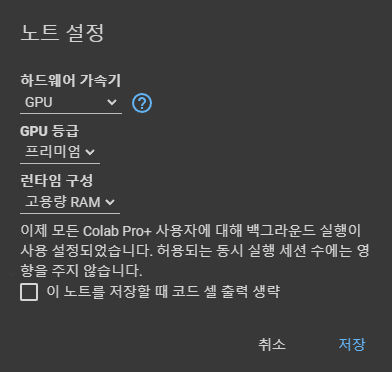

In [171]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [172]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Intall wnadb library and login

In [173]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [174]:
# Log in to your W&B account
import wandb
wandb.login()

True

## ✅ Choose a Pretrained Language Model to Use

- [BERT](https://huggingface.co/docs/transformers/model_doc/bert)
    - [transformers.BertTokenize](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer)
    - [transformers.BertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification)

- [ALBERT](https://huggingface.co/docs/transformers/model_doc/albert)
    - [transformers.AlbertTokenizer](https://huggingface.co/docs/transformers/model_doc/albert#transformers.AlbertTokenizer)
    - [transformers.AlbertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/albert#transformers.AlbertForSequenceClassification)

- [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta)
    - [transformers.RobertaTokenizer](https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaTokenizer)
    - [transformers.RobertaForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaForSequenceClassification)

In [175]:
#MY_MODEL_NAME = 'bert-base'
#MY_MODEL_NAME = 'bert-large'
MY_MODEL_NAME = 'albert-base'
#MY_MODEL_NAME = 'albert-large'
#MY_MODEL_NAME = 'roberta-base'
#MY_MODEL_NAME = 'roberta-large'
#MY_MODEL_NAME = 'electra-base'

## ✅ Choose whether to use small sample of dataset

In [176]:
SMALL_SAMPLE, PERC = True, 0.01 # 데이터셋 일부만 사용하고 싶다면
#SMALL_SAMPLE = False # 전체 데이터셋을 사용하고 싶다면

## Import libraries

In [177]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict
import random
import gc

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import numpy as np
from tqdm import tqdm, trange

import sentencepiece

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    ElectraForSequenceClassification,
    ElectraTokenizer
)

# 📈 For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
# random seed
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1️⃣ Preprocess

In [9]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

## 🔴 Tokenizer

- 원하는 모델이 if 문 안에 있는지 확인

In [10]:
if MY_MODEL_NAME == 'bert-base': tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif MY_MODEL_NAME == 'bert-large': tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
elif MY_MODEL_NAME == 'albert-base': tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
elif MY_MODEL_NAME == 'albert-large': tokenizer = AlbertTokenizer.from_pretrained("albert-large-v2")
elif MY_MODEL_NAME == 'roberta-base': tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
elif MY_MODEL_NAME == 'roberta-large': tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
elif MY_MODEL_NAME == 'electra-base': tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
print(MY_MODEL_NAME)
print(tokenizer)

albert-base
PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev (1).0
Saving sentiment.dev.1 to sentiment.dev (1).1
Saving sentiment.train.0 to sentiment.train (1).0
Saving sentiment.train.1 to sentiment.train (1).1
Saving test_no_label.csv to test_no_label (1).csv


In [ ]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [ ]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


## Visualization

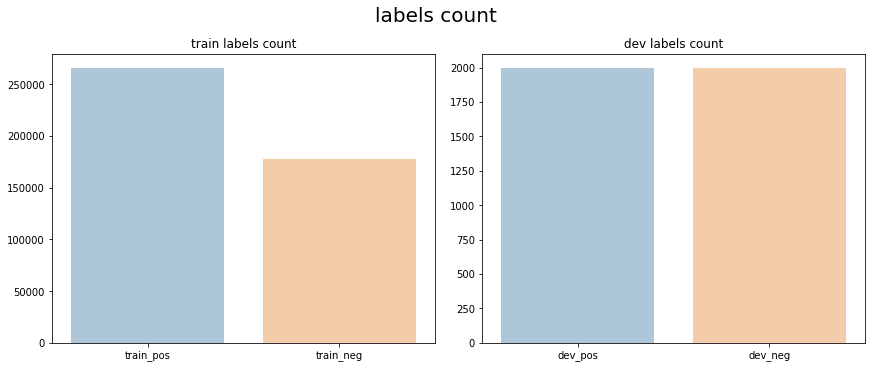

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5), constrained_layout = True)

g1 = sns.barplot(x = np.array(['train_pos', 'train_neg']),
                y = np.array([len(train_pos), len(train_neg)]),
                alpha = .4, ax = ax[0])
g1.set_title("train labels count")

g2 = sns.barplot(x = np.array(['dev_pos', 'dev_neg']),
                y = np.array([len(dev_pos), len(dev_neg)]),
                alpha = .4, ax = ax[1])
g2.set_title("dev labels count")

fig.suptitle('labels count', fontsize=20)
plt.show()

In [ ]:
train_pos[:10]

['2 5977 950 13 9 3',
 '2 18656 7705 365 13 9 3',
 '2 59 67 57 1954 621 18 17 1392 5262 56 25 510 254 13 9 3',
 '2 32 13 22 18 21 254 13865 69 20538 7298 13 9 3',
 '2 14 1138 25 4753 13 9 3',
 '2 254 748 950 13 9 3',
 '2 254 365 13 9 3',
 '2 11554 16 208 25 27269 17 7503 16 621 18 13 9 3',
 '2 374 209 26 4311 54 748 16385 18 17 3911 13 9 3',
 '2 14 78 978 1879 5289 13 9 3']

In [ ]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [ ]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

## Small sample of dataset

- 데이터셋 일부만 사용하고 싶다면

In [ ]:
if SMALL_SAMPLE == True:
    train_dataset_total = SentimentDataset(tokenizer, train_pos, train_neg)
    dev_dataset_total = SentimentDataset(tokenizer, dev_pos, dev_neg)

    train_dataset = random.sample(list(train_dataset_total), int(PERC * len(train_dataset_total)))
    dev_dataset = random.sample(list(dev_dataset_total), int(PERC * len(dev_dataset_total)))

    print(len(train_dataset_total))
    print(len(dev_dataset_total))
    print(len(train_dataset))
    print(len(dev_dataset))

    del train_dataset_total
    del dev_dataset_total
    gc.collect()

443259
4000
4432
40


In [ ]:
# train dataset 10개 인쇄
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    2,    66, 25719, 23507,    25,  1659,  5289,    13,     9,
           3]), array([1]))
(array([   2,   14,  600,   23, 5579,   13,    1, 6336,    1,   13,    9,
          3]), array([0]))
(array([    2,   374, 14219,    17,  3180,  1573, 10081,    13,   187,
           3]), array([1]))
(array([   2, 1138,   25,  550,   91,  119, 4753,   17, 7334,   27,  127,
        564,   50, 9954,   13,    9,    3]), array([1]))
(array([   2,  253, 3180,   13,   18, 9996,   17,  374, 6341,   13,    9,
          3]), array([1]))
(array([   2,   95, 2199,   32,   13,    9,    3]), array([1]))
(array([    2, 14685,    17,  4561,    50,  1123,    13,    15,   626,
         896,    54, 13096,    13,     9,     3]), array([1]))
(array([   2,   32,   23, 4012,   13,   15,   14,  246, 1562, 2120,   31,
         13,   22,  195,   41,   13,    9,    3]), array([1]))
(array([   2,   48,  209,   25, 9080,   13,    9,    3]), array([0]))
(array([    2,    31,  6916,   339,    48, 12165,   488,    13, 

In [ ]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices], batch_first=True)
    attention_mask = torch.tensor([[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

# 2️⃣ Model: Training & Validation

In [ ]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

## Hyperparameter Tuning using WandB 🐝

In [ ]:
def build_optimizer(model, optimizer, learning_rate, weight_decay):
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adamw':
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    return optimizer

### ✅ Define sweep config

- sweep_configuration: Case 1
```
sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': "val/val_accuracy",
    'parameters':
    {
        'batch_size': {'values': [32]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01]},
        'weight_decay': {'values': [0]},
        'epochs': {'values': [1]}
    }
}
```
- sweep_configuration: Case 2
```
sweep_configuration = {
    'method': 'grid', # 'random'
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': "val/val_accuracy"},
    'parameters':
    {
        'batch_size': {'values': [32, 64, 128]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [✅, ✅]},
        'weight_decay': {'values': [1e-04, 1e-05, 0]},
        'epochs': {'values': [1]}
    }
}
```
- sweep_configuration: Case 3
```
sweep_configuration = {
    'method': 'grid', # 'random'
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': "val/val_accuracy"},
    'parameters':
    {
        'batch_size': {'values': [✅]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [✅]},
        'weight_decay': {'values': [0]},
        'epochs': {'values': [1, 3, 5, 10]}
    }
}
```
- [`method`](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#method)
```
'method': 'grid',
```
    - grid: Grid search iterates over all possible combinations of parameter values.
    - random: Random search chooses a random set of values on each iteration.
    - bayes: Our Bayesian hyperparameter search method uses a Gaussian Process to model the relationship between the parameters and the model metric and chooses parameters to optimize the probability of improvement. This strategy requires the metric key to be specified.

In [ ]:
# 🐝 Step 1: Define sweep config
sweep_configuration = {
    'method': 'grid', # 'random'
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': "val/val_accuracy"},
    'parameters':
    {
        'batch_size': {'values': [32]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01]},
        'weight_decay': {'values': [0]},
        'epochs': {'values': [1]}
    }
}

# 🐝 Step 2: Initialize sweep by passing in config
sweep_id = wandb.sweep(sweep=sweep_configuration, project='my-first-sweep')

Create sweep with ID: cc5830xv
Sweep URL: https://wandb.ai/yangdk02/my-first-sweep/sweeps/cc5830xv


### 🔴 Define Pretraind Language Model

- 원하는 모델이 if 문 안에 있는지 확인

In [ ]:
print(MY_MODEL_NAME)

albert-base


### ✅

- [LOWEST_VAL_ACC]보다 크면 parameters 저장 → Checkpoint
```
LOWEST_VAL_ACC = 0.9
(중략)
                    if val_acc > LOWEST_VAL_ACC:
                        torch.save(model.state_dict(), my_name)
```
- 맨 마지막에 parameters 저장
```
    # 💾 학습이 완료되면 최종 parameters를 저장
    torch.save(model.state_dict(), my_name + '.bin')
```

In [ ]:
# Choose whether to draw loss graph using Matplotlip
DRAW_GRAPH = True # 그래프를 그리고 싶다면
#DRAW_GRAPH = False # 그래프를 그리고 싶지 않다면

# Determine how many times to validate per epoch
VALID_INTERVAL = 5 # 5 (권장)

# Determine minimum validation accuracy
LOWEST_VAL_ACC = 0.9

In [ ]:
# 🐝 Step 3: Define training function that takes in hyperparameter 
# values from `wandb.config` and uses them to train a model and return metric
def main():
    # 🐝 initialise a wandb run
    # Use the wandb.init() API to generate a background process 
    # to sync and log data as a Weights and Biases run.
    # Optionally provide the name of the project.
    # 🐝 initialise a wandb run
    run = wandb.init(project='my-first-sweep')

    # note that we define values from `wandb.config` instead of 
    # defining hard values
    batch_size = wandb.config.batch_size
    optim = wandb.config.optimizer
    lr  =  wandb.config.lr
    weight_decay = wandb.config.weight_decay
    epochs = wandb.config.epochs

    my_name = "model_" + MY_MODEL_NAME + "_" + str(batch_size) + "_" + str(optim) + "_" + str(lr) + "_" + str(weight_decay) + "_" + str(epochs)
    run.name = my_name

    # Get the data
    train_loader = torch.utils.data.DataLoader( # Train dataset
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_style,
        pin_memory=True, num_workers=2)
    dev_loader = torch.utils.data.DataLoader( # Validation dataset
        dev_dataset,
        batch_size=batch_size*2,
        shuffle=False,
        collate_fn=collate_fn_style,
        num_workers=2)
    
    if MY_MODEL_NAME == 'bert-base': model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    elif MY_MODEL_NAME == 'bert-large': model = BertForSequenceClassification.from_pretrained('bert-large-uncased')
    elif MY_MODEL_NAME == 'albert-base': model = AlbertForSequenceClassification.from_pretrained("albert-base-v2")
    elif MY_MODEL_NAME == 'albert-large': model = AlbertForSequenceClassification.from_pretrained("albert-large-v2")
    elif MY_MODEL_NAME == 'roberta-base': model = RobertaForSequenceClassification.from_pretrained("roberta-base")
    elif MY_MODEL_NAME == 'roberta-large': model = RobertaForSequenceClassification.from_pretrained("roberta-large")
    elif MY_MODEL_NAME == 'electra-base': model = ElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion")
    model.to(device)

    # Make the loss and optimizer
    optimizer = build_optimizer(model, optim, lr, weight_decay)

     # 📈 For visualization using Matplotlib
    train_loss_history = []
    valid_loss_history = []

    # Training
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
                model.train()
                tepoch.set_description(f"Epoch {epoch}")
                
                # Train
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                position_ids = position_ids.to(device)
                labels = labels.to(device, dtype=torch.long)

                optimizer.zero_grad()
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    position_ids=position_ids,
                    labels=labels)
                train_loss = outputs.loss
                train_loss.backward()
                optimizer.step()
                
                # 🐝 Log train metrics to wandb 
                wandb.log({
                    "train/epoch": epoch,
                    "train/train_loss": train_loss
                })

                tepoch.set_postfix(loss=train_loss.item())

                if iteration != 0 and iteration % int(len(train_loader) / VALID_INTERVAL) == 0:
                    # Evaluate the model [VALID_INTERVAL] times per epoch
                    model.eval()
                    with torch.no_grad():
                        val_losses = []
                        predictions = []
                        target_labels = []
                        for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(
                            dev_loader,
                            desc='Eval',
                            position=1,
                            leave=None):
                            # Validation
                            input_ids = input_ids.to(device)
                            attention_mask = attention_mask.to(device)
                            token_type_ids = token_type_ids.to(device)
                            position_ids = position_ids.to(device)
                            labels = labels.to(device, dtype=torch.long)

                            outputs = model(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                labels=labels)
                            loss = outputs.loss
                            logits = outputs.logits
                            val_losses.append(loss.item())

                            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                            batch_labels = [int(example) for example in labels]

                            predictions += batch_predictions
                            target_labels += batch_labels
                    
                    val_loss = sum(val_losses) / len(val_losses)
                    val_acc = compute_acc(predictions, target_labels)

                    # 🐝 Log validation metrics to wandb
                    wandb.log({
                        "val/val_accuracy": val_acc,
                        "val/val_loss": val_loss
                    })
                    train_loss_history.append(train_loss)  # 📈 For visualization using Matplotlib
                    valid_loss_history.append(val_loss)  # 📈 For visualization using Matplotlib
                    print('=====> val_acc: ', val_acc)
                    
                    # 💾 [LOWEST_VAL_ACC]보다 크면 parameters 저장
                    if val_acc > LOWEST_VAL_ACC:
                        torch.save(model.state_dict(), my_name + '_ckp.bin') # checkpoint
                        print('\nSaved the model!')

    # 💾 학습이 완료되면 최종 parameters를 저장
    torch.save(model.state_dict(), my_name + '.bin')

    if DRAW_GRAPH:
        # 📈 For visualization using Matplotlib
        # 간단하게 train loss & validation loss 시각화
        train_loss_history = torch.tensor(train_loss_history).detach().cpu().numpy()
        valid_loss_history = torch.tensor(valid_loss_history).detach().cpu().numpy()
        plt.plot(train_loss_history, label = "Train Loss")
        plt.plot(valid_loss_history, label = "Validation Loss")
        plt.title('Loss (' + my_name + ')')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(my_name + '.png') # 💾
        plt.close()

- [`wnadb.agent`](https://docs.wandb.ai/ref/python/agent)
    - count
(int, optional) the number of trials to run.

In [ ]:
# 🐝 Step 4: Call to `wandb.agent` to start a sweep
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: 6hdecxtl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: Currently logged in as: yangdk02. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  22%|██▏       | 30/139 [00:05<00:07, 13.78batch/s, loss=8.56]

=====> val_acc:  0.575


Epoch 0:  31%|███       | 43/139 [00:06<00:06, 14.52batch/s, loss=3.64]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 56/139 [00:07<00:05, 15.23batch/s, loss=2.41]

=====> val_acc:  0.425


Epoch 0:  50%|█████     | 70/139 [00:08<00:04, 15.79batch/s, loss=5.34]

=====> val_acc:  0.575


Epoch 0:  59%|█████▉    | 82/139 [00:08<00:03, 15.67batch/s, loss=3.66]

=====> val_acc:  0.575


Epoch 0:  67%|██████▋   | 93/139 [00:09<00:03, 13.67batch/s, loss=10.9]

=====> val_acc:  0.425


Epoch 0:  78%|███████▊  | 109/139 [00:10<00:01, 15.37batch/s, loss=6.44]

=====> val_acc:  0.425


Epoch 0:  87%|████████▋ | 121/139 [00:11<00:01, 15.61batch/s, loss=5.25]

=====> val_acc:  0.425


Epoch 0:  96%|█████████▋| 134/139 [00:12<00:00, 15.23batch/s, loss=1.88]

=====> val_acc:  0.425


Epoch 1:  12%|█▏        | 16/139 [00:01<00:08, 14.47batch/s, loss=1.57]

=====> val_acc:  0.575


Epoch 1:  22%|██▏       | 30/139 [00:01<00:07, 15.39batch/s, loss=9.63]

=====> val_acc:  0.425


Epoch 1:  31%|███       | 43/139 [00:02<00:06, 15.33batch/s, loss=8.78]

=====> val_acc:  0.575


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.83batch/s, loss=2.21]

=====> val_acc:  0.425


Epoch 1:  49%|████▉     | 68/139 [00:04<00:04, 15.08batch/s, loss=8.61]

=====> val_acc:  0.575


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:03, 15.03batch/s, loss=10.3]

=====> val_acc:  0.575


Epoch 1:  68%|██████▊   | 94/139 [00:06<00:03, 14.65batch/s, loss=18.7]

=====> val_acc:  0.425


Epoch 1:  78%|███████▊  | 108/139 [00:06<00:02, 14.98batch/s, loss=18.4]

=====> val_acc:  0.425


Epoch 1:  87%|████████▋ | 121/139 [00:07<00:01, 14.98batch/s, loss=1.68]

=====> val_acc:  0.425


Epoch 1:  97%|█████████▋| 135/139 [00:08<00:00, 15.22batch/s, loss=6.72]

=====> val_acc:  0.575


Epoch 2:  12%|█▏        | 16/139 [00:01<00:08, 14.54batch/s, loss=2.16]

=====> val_acc:  0.425


Epoch 2:  22%|██▏       | 30/139 [00:01<00:07, 15.37batch/s, loss=1.52]

=====> val_acc:  0.425


Epoch 2:  32%|███▏      | 44/139 [00:02<00:06, 15.57batch/s, loss=25.7]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 56/139 [00:03<00:05, 15.54batch/s, loss=1.66]

=====> val_acc:  0.425


Epoch 2:  50%|█████     | 70/139 [00:04<00:04, 15.33batch/s, loss=12.9]

=====> val_acc:  0.425


Epoch 2:  59%|█████▉    | 82/139 [00:05<00:03, 14.26batch/s, loss=4.75]

=====> val_acc:  0.575


Epoch 2:  68%|██████▊   | 95/139 [00:06<00:03, 14.62batch/s, loss=6.1]

=====> val_acc:  0.425


Epoch 2:  78%|███████▊  | 109/139 [00:06<00:01, 15.22batch/s, loss=4.71]

=====> val_acc:  0.425


Epoch 2:  87%|████████▋ | 121/139 [00:07<00:01, 15.28batch/s, loss=2.26]

=====> val_acc:  0.425


Epoch 2:  97%|█████████▋| 135/139 [00:08<00:00, 15.43batch/s, loss=5.8]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.93batch/s, loss=1.69]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▄▁▃▁▁▁▂▂▄▂▂▂▁▂▂▂▁▂▃▁▄▄▂▂▂▃▂▁▃▅▆▄▂▂▂▁▂▁▁
val/val_accuracy,██▁▁██▁▁▁▁█▁█▁██▁▁▁█▁▁▁▁▁█▁▁▁▁
val/val_loss,▅▂▂▁▁▁▃▂▃▁▁▃▁▁▃▃▃▃▂▁▁▁▄█▄▂▂▁▂▁
train/epoch,2
train/train_loss,1.68689
val/val_accuracy,0.425
val/val_loss,0.90716


wandb: Agent Starting Run: 5a396cg2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  21%|██        | 29/139 [00:01<00:07, 14.22batch/s, loss=11]

=====> val_acc:  0.425


Epoch 0:  30%|███       | 42/139 [00:02<00:06, 14.55batch/s, loss=7.58]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 56/139 [00:03<00:05, 15.29batch/s, loss=16.4]

=====> val_acc:  0.425


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.32batch/s, loss=6.39]

=====> val_acc:  0.575


Epoch 0:  58%|█████▊    | 80/139 [00:05<00:04, 13.15batch/s, loss=4.14]

=====> val_acc:  0.425


Epoch 0:  69%|██████▉   | 96/139 [00:06<00:02, 15.20batch/s, loss=15.3]

=====> val_acc:  0.425


Epoch 0:  78%|███████▊  | 109/139 [00:06<00:01, 15.25batch/s, loss=3.17]

=====> val_acc:  0.425


Epoch 0:  86%|████████▌ | 119/139 [00:07<00:01, 13.47batch/s, loss=7.85]

=====> val_acc:  0.575


Epoch 0:  96%|█████████▋| 134/139 [00:08<00:00, 13.98batch/s, loss=9.06]

=====> val_acc:  0.575


Epoch 1:  12%|█▏        | 16/139 [00:01<00:08, 14.16batch/s, loss=3.49]

=====> val_acc:  0.425


Epoch 1:  21%|██        | 29/139 [00:01<00:07, 14.78batch/s, loss=2.44]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.69batch/s, loss=2.78]

=====> val_acc:  0.575


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.48batch/s, loss=9.87]

=====> val_acc:  0.425


Epoch 1:  50%|████▉     | 69/139 [00:04<00:04, 15.47batch/s, loss=6.23]

=====> val_acc:  0.425


Epoch 1:  60%|█████▉    | 83/139 [00:05<00:03, 15.44batch/s, loss=2.67]

=====> val_acc:  0.425


Epoch 1:  68%|██████▊   | 95/139 [00:06<00:02, 14.76batch/s, loss=6.96]

=====> val_acc:  0.425


Epoch 1:  78%|███████▊  | 108/139 [00:06<00:02, 15.17batch/s, loss=2.5]

=====> val_acc:  0.575


Epoch 1:  86%|████████▌ | 119/139 [00:07<00:01, 13.39batch/s, loss=8.27]

=====> val_acc:  0.425


Epoch 1:  96%|█████████▋| 134/139 [00:08<00:00, 14.86batch/s, loss=1.59]

=====> val_acc:  0.575


Epoch 2:  12%|█▏        | 17/139 [00:01<00:08, 15.23batch/s, loss=10.3]

=====> val_acc:  0.425


Epoch 2:  22%|██▏       | 31/139 [00:01<00:07, 15.34batch/s, loss=6.14]

=====> val_acc:  0.575


Epoch 2:  32%|███▏      | 44/139 [00:02<00:06, 15.38batch/s, loss=2.42]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 56/139 [00:03<00:05, 15.33batch/s, loss=9.94]

=====> val_acc:  0.575


Epoch 2:  49%|████▉     | 68/139 [00:04<00:04, 14.63batch/s, loss=6.93]

=====> val_acc:  0.425


Epoch 2:  59%|█████▉    | 82/139 [00:05<00:03, 14.38batch/s, loss=14.4]

=====> val_acc:  0.575


Epoch 2:  69%|██████▉   | 96/139 [00:06<00:02, 15.05batch/s, loss=3.01]

=====> val_acc:  0.425


Epoch 2:  78%|███████▊  | 108/139 [00:06<00:02, 15.20batch/s, loss=2.12]

=====> val_acc:  0.425


Epoch 2:  87%|████████▋ | 121/139 [00:07<00:01, 15.10batch/s, loss=1.74]

=====> val_acc:  0.425


Epoch 2:  96%|█████████▌| 133/139 [00:08<00:00, 14.32batch/s, loss=2.83]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.85batch/s, loss=3.53]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▃▂▁▂▂▁▁▃▃▂▁▂▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▂▁▃▃▂▁▃▁▂▁▁▁
val/val_accuracy,█▁▁▁█▁▁▁██▁▁█▁▁▁▁█▁█▁█▁█▁█▁▁▁▁
val/val_loss,▄▃▂▂▂▃█▅▃▂▁▂▁▆▂▁▅▂▄▁▂▃▅▂▂▂▅▄▂▂
train/epoch,2
train/train_loss,3.52837
val/val_accuracy,0.425
val/val_loss,5.34652


wandb: Agent Starting Run: ipr4dotj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  22%|██▏       | 30/139 [00:02<00:07, 14.92batch/s, loss=16.9]

=====> val_acc:  0.575


Epoch 0:  30%|███       | 42/139 [00:02<00:06, 14.18batch/s, loss=5.96]

=====> val_acc:  0.575


Epoch 0:  40%|████      | 56/139 [00:03<00:05, 15.26batch/s, loss=6.03]

=====> val_acc:  0.425


Epoch 0:  48%|████▊     | 67/139 [00:04<00:05, 13.58batch/s, loss=8.64]

=====> val_acc:  0.425


Epoch 0:  58%|█████▊    | 80/139 [00:05<00:04, 13.45batch/s, loss=5.44]

=====> val_acc:  0.575


Epoch 0:  68%|██████▊   | 94/139 [00:06<00:03, 14.78batch/s, loss=2.42]

=====> val_acc:  0.425


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.70batch/s, loss=11.8]

=====> val_acc:  0.425


Epoch 0:  86%|████████▋ | 120/139 [00:07<00:01, 14.75batch/s, loss=4.24]

=====> val_acc:  0.425


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.48batch/s, loss=11.2]

=====> val_acc:  0.575


Epoch 1:  13%|█▎        | 18/139 [00:01<00:07, 15.21batch/s, loss=2.05]

=====> val_acc:  0.425


Epoch 1:  21%|██        | 29/139 [00:01<00:07, 14.79batch/s, loss=2.61]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.75batch/s, loss=4.32]

=====> val_acc:  0.425


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.20batch/s, loss=4.07]

=====> val_acc:  0.425


Epoch 1:  49%|████▉     | 68/139 [00:04<00:04, 14.50batch/s, loss=5.98]

=====> val_acc:  0.575


Epoch 1:  60%|█████▉    | 83/139 [00:05<00:03, 14.97batch/s, loss=6.76]

=====> val_acc:  0.425


Epoch 1:  69%|██████▉   | 96/139 [00:06<00:02, 15.08batch/s, loss=2.76]

=====> val_acc:  0.575


Epoch 1:  78%|███████▊  | 109/139 [00:06<00:01, 15.24batch/s, loss=5.6]

=====> val_acc:  0.575


Epoch 1:  86%|████████▋ | 120/139 [00:07<00:01, 14.91batch/s, loss=3.07]

=====> val_acc:  0.425


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.68batch/s, loss=11.1]

=====> val_acc:  0.425


Epoch 2:  12%|█▏        | 16/139 [00:01<00:08, 14.35batch/s, loss=7.42]

=====> val_acc:  0.425


Epoch 2:  21%|██        | 29/139 [00:01<00:07, 14.52batch/s, loss=1.97]

=====> val_acc:  0.575


Epoch 2:  30%|███       | 42/139 [00:02<00:06, 14.59batch/s, loss=4.1]

=====> val_acc:  0.575


Epoch 2:  40%|████      | 56/139 [00:03<00:05, 15.25batch/s, loss=2.01]

=====> val_acc:  0.575


Epoch 2:  50%|████▉     | 69/139 [00:04<00:04, 15.30batch/s, loss=3.94]

=====> val_acc:  0.425


Epoch 2:  60%|█████▉    | 83/139 [00:05<00:03, 15.29batch/s, loss=1.61]

=====> val_acc:  0.575


Epoch 2:  69%|██████▉   | 96/139 [00:06<00:02, 15.39batch/s, loss=2.42]

=====> val_acc:  0.425


Epoch 2:  78%|███████▊  | 109/139 [00:06<00:01, 15.14batch/s, loss=9.48]

=====> val_acc:  0.425


Epoch 2:  87%|████████▋ | 121/139 [00:07<00:01, 15.34batch/s, loss=3.94]

=====> val_acc:  0.425


Epoch 2:  97%|█████████▋| 135/139 [00:08<00:00, 15.33batch/s, loss=3.32]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.89batch/s, loss=13]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▂▆▄▄▅▂▃▄▄▂▂▂▃▂▁▂▂▇▃▁▄▁▁▂▁██▅▄▁▄▁▂▄▂▁▂▁▄▁
val/val_accuracy,███▁▁█▁▁▁█▁▁▁▁█▁██▁▁▁███▁█▁▁▁▁
val/val_loss,▄▁▃▂▁▃▁▅▄▂▁▁▅▁▁▇▁▁▁█▆▁▁▁▃▂▃▃▅▃
train/epoch,2
train/train_loss,13.02223
val/val_accuracy,0.425
val/val_loss,9.05063


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kk0qtlm3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  21%|██        | 29/139 [00:01<00:07, 14.62batch/s, loss=0.868]

=====> val_acc:  0.425


Epoch 0:  30%|███       | 42/139 [00:02<00:06, 14.60batch/s, loss=0.672]

=====> val_acc:  0.425


Epoch 0:  40%|███▉      | 55/139 [00:03<00:05, 14.76batch/s, loss=0.735]

=====> val_acc:  0.425


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.77batch/s, loss=0.661]

=====> val_acc:  0.425


Epoch 0:  60%|█████▉    | 83/139 [00:05<00:03, 15.04batch/s, loss=0.803]

=====> val_acc:  0.575


Epoch 0:  68%|██████▊   | 95/139 [00:06<00:03, 14.31batch/s, loss=0.936]

=====> val_acc:  0.425


Epoch 0:  78%|███████▊  | 108/139 [00:06<00:02, 14.58batch/s, loss=1.06]

=====> val_acc:  0.425


Epoch 0:  88%|████████▊ | 122/139 [00:07<00:01, 15.27batch/s, loss=0.726]

=====> val_acc:  0.425


Epoch 0:  97%|█████████▋| 135/139 [00:08<00:00, 15.13batch/s, loss=0.723]

=====> val_acc:  0.575


Epoch 1:  11%|█         | 15/139 [00:01<00:09, 12.62batch/s, loss=0.725]

=====> val_acc:  0.575


Epoch 1:  22%|██▏       | 30/139 [00:02<00:07, 15.03batch/s, loss=0.645]

=====> val_acc:  0.575


Epoch 1:  31%|███       | 43/139 [00:02<00:06, 14.70batch/s, loss=0.91]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 56/139 [00:03<00:05, 14.61batch/s, loss=0.724]

=====> val_acc:  0.425


Epoch 1:  50%|█████     | 70/139 [00:04<00:04, 15.11batch/s, loss=1.24]

=====> val_acc:  0.425


Epoch 1:  60%|█████▉    | 83/139 [00:05<00:03, 15.08batch/s, loss=0.79]

=====> val_acc:  0.575


Epoch 1:  68%|██████▊   | 95/139 [00:06<00:03, 14.34batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 1:  78%|███████▊  | 109/139 [00:06<00:01, 15.02batch/s, loss=0.652]

=====> val_acc:  0.575


Epoch 1:  87%|████████▋ | 121/139 [00:07<00:01, 14.98batch/s, loss=0.773]

=====> val_acc:  0.425


Epoch 1:  97%|█████████▋| 135/139 [00:08<00:00, 15.33batch/s, loss=0.56]

=====> val_acc:  0.425


Epoch 2:  12%|█▏        | 17/139 [00:01<00:08, 14.90batch/s, loss=0.874]

=====> val_acc:  0.575


Epoch 2:  22%|██▏       | 30/139 [00:01<00:07, 15.15batch/s, loss=0.88]

=====> val_acc:  0.425


Epoch 2:  31%|███       | 43/139 [00:02<00:06, 14.73batch/s, loss=0.733]

=====> val_acc:  0.575


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.48batch/s, loss=0.905]

=====> val_acc:  0.425


Epoch 2:  50%|████▉     | 69/139 [00:04<00:04, 15.21batch/s, loss=1.44] 

=====> val_acc:  0.575


Epoch 2:  59%|█████▉    | 82/139 [00:05<00:03, 14.93batch/s, loss=1.18]

=====> val_acc:  0.425


Epoch 2:  68%|██████▊   | 94/139 [00:06<00:03, 14.22batch/s, loss=1.18]

=====> val_acc:  0.425


Epoch 2:  77%|███████▋  | 107/139 [00:06<00:02, 14.39batch/s, loss=1.62]

=====> val_acc:  0.425


Epoch 2:  88%|████████▊ | 122/139 [00:07<00:01, 15.26batch/s, loss=0.704]

=====> val_acc:  0.425


Epoch 2:  96%|█████████▋| 134/139 [00:08<00:00, 15.38batch/s, loss=1.81]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.85batch/s, loss=1.42]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,██▂▁▁▁▁▁▁▁▂▂▁▂▃▁▁▁▂▃▁▁▂▁▄▂▂▁▂▂▁▁▁▁▂▂▁▃▄▂
val/val_accuracy,▁▁▁▁▁█▁▁▁███▁▁▁█▁█▁▁█▁█▁█▁▁▁▁▁
val/val_loss,▁▁▂▁▁▁▁▄▂▁▁▁▁▃▂▁▂▁▅▂▁▄▁▃▁▁▂▃▃█
train/epoch,2
train/train_loss,1.41822
val/val_accuracy,0.425
val/val_loss,2.57808


wandb: Agent Starting Run: mc06bz73 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  21%|██        | 29/139 [00:02<00:07, 14.15batch/s, loss=1.13]

=====> val_acc:  0.425


Epoch 0:  30%|███       | 42/139 [00:02<00:06, 14.72batch/s, loss=0.903]

=====> val_acc:  0.425


Epoch 0:  40%|███▉      | 55/139 [00:03<00:05, 14.81batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.60batch/s, loss=0.665]

=====> val_acc:  0.425


Epoch 0:  58%|█████▊    | 81/139 [00:05<00:03, 14.87batch/s, loss=0.756]

=====> val_acc:  0.425


Epoch 0:  68%|██████▊   | 95/139 [00:06<00:02, 15.41batch/s, loss=0.776]

=====> val_acc:  0.425


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.43batch/s, loss=0.877]

=====> val_acc:  0.425


Epoch 0:  88%|████████▊ | 122/139 [00:07<00:01, 14.67batch/s, loss=0.843]

=====> val_acc:  0.575


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.63batch/s, loss=1.1]

=====> val_acc:  0.425


Epoch 1:  12%|█▏        | 16/139 [00:01<00:08, 14.64batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 1:  21%|██        | 29/139 [00:01<00:07, 14.83batch/s, loss=0.674]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.60batch/s, loss=1.3] 

=====> val_acc:  0.425


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.74batch/s, loss=1.01]

=====> val_acc:  0.425


Epoch 1:  49%|████▉     | 68/139 [00:04<00:04, 14.79batch/s, loss=0.726]

=====> val_acc:  0.575


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:03, 14.77batch/s, loss=0.806]

=====> val_acc:  0.425


Epoch 1:  68%|██████▊   | 94/139 [00:06<00:03, 14.78batch/s, loss=0.887]

=====> val_acc:  0.425


Epoch 1:  78%|███████▊  | 108/139 [00:06<00:02, 14.87batch/s, loss=1.46]

=====> val_acc:  0.575


Epoch 1:  87%|████████▋ | 121/139 [00:07<00:01, 14.71batch/s, loss=0.938]

=====> val_acc:  0.575


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.46batch/s, loss=1.32]

=====> val_acc:  0.575


Epoch 2:  13%|█▎        | 18/139 [00:01<00:08, 14.77batch/s, loss=1.54]

=====> val_acc:  0.575


Epoch 2:  21%|██        | 29/139 [00:01<00:07, 14.50batch/s, loss=1.46]

=====> val_acc:  0.575


Epoch 2:  30%|███       | 42/139 [00:02<00:06, 14.52batch/s, loss=0.813]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 56/139 [00:03<00:05, 15.23batch/s, loss=1.3]

=====> val_acc:  0.425


Epoch 2:  50%|█████     | 70/139 [00:04<00:04, 15.37batch/s, loss=1.36]

=====> val_acc:  0.425


Epoch 2:  58%|█████▊    | 80/139 [00:05<00:04, 13.22batch/s, loss=0.7] 

=====> val_acc:  0.425


Epoch 2:  69%|██████▉   | 96/139 [00:06<00:02, 15.05batch/s, loss=0.561]

=====> val_acc:  0.425


Epoch 2:  78%|███████▊  | 109/139 [00:06<00:01, 15.07batch/s, loss=0.716]

=====> val_acc:  0.425


Epoch 2:  86%|████████▋ | 120/139 [00:07<00:01, 14.62batch/s, loss=0.826]

=====> val_acc:  0.425


Epoch 2:  96%|█████████▌| 133/139 [00:08<00:00, 14.66batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.76batch/s, loss=0.642]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▅▁▁▂▂▁▁▂▂▁▂▂▂▂▂▂▂▁▅▁▂▁▁▁▄█▃▃▄▄▃▂▂▃▁▁▂▁▂▂
val/val_accuracy,█▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁█████▁▁▁▁▁▁▁▁
val/val_loss,▂▁▂▁▁▂▃▂▁▄▁▄▁▁▁▁▄▃▃█▃▃▃▅▇▃▂▂▂▁
train/epoch,2
train/train_loss,0.64186
val/val_accuracy,0.425
val/val_loss,0.70157


wandb: Agent Starting Run: v3b0p50i with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  21%|██        | 29/139 [00:02<00:08, 12.97batch/s, loss=0.838]

=====> val_acc:  0.425


Epoch 0:  31%|███       | 43/139 [00:02<00:07, 13.60batch/s, loss=0.789]

=====> val_acc:  0.425


Epoch 0:  41%|████      | 57/139 [00:03<00:05, 14.59batch/s, loss=0.795]

=====> val_acc:  0.575


Epoch 0:  50%|█████     | 70/139 [00:04<00:04, 15.06batch/s, loss=0.69]

=====> val_acc:  0.425


Epoch 0:  58%|█████▊    | 81/139 [00:05<00:03, 14.71batch/s, loss=2.14]

=====> val_acc:  0.575


Epoch 0:  68%|██████▊   | 94/139 [00:06<00:03, 14.84batch/s, loss=0.779]

=====> val_acc:  0.425


Epoch 0:  78%|███████▊  | 109/139 [00:07<00:01, 15.03batch/s, loss=0.662]

=====> val_acc:  0.425


Epoch 0:  88%|████████▊ | 122/139 [00:07<00:01, 15.03batch/s, loss=1.34]

=====> val_acc:  0.425


Epoch 0:  95%|█████████▍| 132/139 [00:08<00:00, 13.27batch/s, loss=1.33]

=====> val_acc:  0.425


Epoch 1:  12%|█▏        | 16/139 [00:01<00:08, 14.64batch/s, loss=0.758]

=====> val_acc:  0.425


Epoch 1:  20%|██        | 28/139 [00:02<00:08, 13.45batch/s, loss=0.779]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.26batch/s, loss=0.759]

=====> val_acc:  0.425


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.52batch/s, loss=0.819]

=====> val_acc:  0.425


Epoch 1:  50%|█████     | 70/139 [00:04<00:04, 15.11batch/s, loss=0.716]

=====> val_acc:  0.425


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:04, 14.31batch/s, loss=0.761]

=====> val_acc:  0.425


Epoch 1:  69%|██████▉   | 96/139 [00:06<00:02, 15.16batch/s, loss=1.15]

=====> val_acc:  0.575


Epoch 1:  77%|███████▋  | 107/139 [00:06<00:02, 14.57batch/s, loss=1.13]

=====> val_acc:  0.425


Epoch 1:  86%|████████▋ | 120/139 [00:07<00:01, 14.64batch/s, loss=0.926]

=====> val_acc:  0.425


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.71batch/s, loss=0.545]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 18/139 [00:01<00:08, 14.94batch/s, loss=0.827]

=====> val_acc:  0.575


Epoch 2:  21%|██        | 29/139 [00:01<00:07, 14.64batch/s, loss=0.988]

=====> val_acc:  0.425


Epoch 2:  30%|███       | 42/139 [00:02<00:06, 14.90batch/s, loss=0.866]

=====> val_acc:  0.425


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.74batch/s, loss=1.08]

=====> val_acc:  0.575


Epoch 2:  49%|████▉     | 68/139 [00:04<00:04, 14.68batch/s, loss=0.757]

=====> val_acc:  0.425


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:04, 14.39batch/s, loss=1.18]

=====> val_acc:  0.575


Epoch 2:  68%|██████▊   | 94/139 [00:06<00:03, 14.61batch/s, loss=1.16]

=====> val_acc:  0.575


Epoch 2:  78%|███████▊  | 108/139 [00:06<00:02, 15.33batch/s, loss=0.644]

=====> val_acc:  0.425


Epoch 2:  87%|████████▋ | 121/139 [00:07<00:01, 14.89batch/s, loss=0.909]

=====> val_acc:  0.575


Epoch 2:  95%|█████████▍| 132/139 [00:08<00:00, 13.46batch/s, loss=0.77]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.87batch/s, loss=0.693]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val/val_accuracy,▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁█▁██▁█▁
val/val_loss,▂▃▃▁▅▁▁▂▆█▄▂▁▇▃▂▂▂▁▁▁▁▂▂▄▂▁▂▁▂
train/epoch,2
train/train_loss,0.69307
val/val_accuracy,0.425
val/val_loss,0.85628


wandb: Agent Starting Run: 2wx0q3ca with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  21%|██        | 29/139 [00:01<00:07, 14.48batch/s, loss=0.719]

=====> val_acc:  0.575


Epoch 0:  31%|███       | 43/139 [00:02<00:06, 14.11batch/s, loss=0.718]

=====> val_acc:  0.425


Epoch 0:  40%|███▉      | 55/139 [00:03<00:05, 14.09batch/s, loss=0.684]

=====> val_acc:  0.425


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.63batch/s, loss=0.665]

=====> val_acc:  0.425


Epoch 0:  58%|█████▊    | 81/139 [00:05<00:03, 14.74batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 0:  68%|██████▊   | 95/139 [00:06<00:02, 15.24batch/s, loss=0.738]

=====> val_acc:  0.425


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.41batch/s, loss=0.686]

=====> val_acc:  0.575


Epoch 0:  86%|████████▋ | 120/139 [00:07<00:01, 14.72batch/s, loss=0.821]

=====> val_acc:  0.425


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.48batch/s, loss=0.712]

=====> val_acc:  0.425


Epoch 1:  12%|█▏        | 16/139 [00:01<00:08, 14.20batch/s, loss=0.615]

=====> val_acc:  0.425


Epoch 1:  22%|██▏       | 31/139 [00:02<00:07, 14.90batch/s, loss=0.727]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.67batch/s, loss=0.671]

=====> val_acc:  0.575


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.49batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 1:  49%|████▉     | 68/139 [00:04<00:04, 14.61batch/s, loss=0.688]

=====> val_acc:  0.425


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:03, 14.58batch/s, loss=0.69] 

=====> val_acc:  0.425


Epoch 1:  68%|██████▊   | 94/139 [00:06<00:03, 14.68batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 1:  77%|███████▋  | 107/139 [00:06<00:02, 14.35batch/s, loss=0.741]

=====> val_acc:  0.425


Epoch 1:  87%|████████▋ | 121/139 [00:07<00:01, 14.30batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 1:  97%|█████████▋| 135/139 [00:08<00:00, 15.22batch/s, loss=0.664]

=====> val_acc:  0.425


Epoch 2:  12%|█▏        | 16/139 [00:01<00:08, 14.62batch/s, loss=0.69]

=====> val_acc:  0.575


Epoch 2:  22%|██▏       | 31/139 [00:02<00:07, 15.08batch/s, loss=0.649]

=====> val_acc:  0.575


Epoch 2:  31%|███       | 43/139 [00:02<00:06, 15.38batch/s, loss=0.665]

=====> val_acc:  0.575


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.41batch/s, loss=0.695]

=====> val_acc:  0.425


Epoch 2:  49%|████▉     | 68/139 [00:04<00:04, 14.33batch/s, loss=0.687]

=====> val_acc:  0.425


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:03, 14.84batch/s, loss=0.69]

=====> val_acc:  0.425


Epoch 2:  68%|██████▊   | 95/139 [00:06<00:02, 14.91batch/s, loss=0.705]

=====> val_acc:  0.425


Epoch 2:  77%|███████▋  | 107/139 [00:06<00:02, 14.28batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 2:  86%|████████▋ | 120/139 [00:07<00:01, 14.66batch/s, loss=0.744]

=====> val_acc:  0.425


Epoch 2:  96%|█████████▋| 134/139 [00:08<00:00, 15.15batch/s, loss=0.725]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.74batch/s, loss=0.698]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▃▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▂▂▂▁▂▂▁▁▂▂▂▂▂▂▂
val/val_accuracy,▁█▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁███▁▁▁▁▁▁▁
val/val_loss,▂▂▂▃▆█▅▁▂▅▄▂▁▃▇▆▃▃▅▆▁▁▁▂▂▅▇▆▃▃
train/epoch,2
train/train_loss,0.69839
val/val_accuracy,0.425
val/val_loss,0.73355


wandb: Agent Starting Run: 070rbifu with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  21%|██        | 29/139 [00:01<00:07, 14.86batch/s, loss=0.818]

=====> val_acc:  0.425


Epoch 0:  31%|███       | 43/139 [00:02<00:06, 14.44batch/s, loss=0.941]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 56/139 [00:03<00:05, 15.18batch/s, loss=0.664]

=====> val_acc:  0.425


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.41batch/s, loss=0.726]

=====> val_acc:  0.425


Epoch 0:  59%|█████▉    | 82/139 [00:05<00:03, 15.11batch/s, loss=0.681]

=====> val_acc:  0.425


Epoch 0:  68%|██████▊   | 94/139 [00:06<00:03, 14.40batch/s, loss=0.684]

=====> val_acc:  0.425


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.72batch/s, loss=0.755]

=====> val_acc:  0.425


Epoch 0:  86%|████████▋ | 120/139 [00:07<00:01, 14.42batch/s, loss=0.688]

=====> val_acc:  0.425


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.64batch/s, loss=0.704]

=====> val_acc:  0.425


Epoch 1:  12%|█▏        | 17/139 [00:01<00:08, 14.56batch/s, loss=0.723]

=====> val_acc:  0.575


Epoch 1:  21%|██        | 29/139 [00:01<00:07, 14.40batch/s, loss=0.63]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.26batch/s, loss=0.753]

=====> val_acc:  0.425


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.60batch/s, loss=0.76]

=====> val_acc:  0.425


Epoch 1:  50%|████▉     | 69/139 [00:04<00:04, 14.43batch/s, loss=0.725]

=====> val_acc:  0.425


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:04, 13.92batch/s, loss=0.726]

=====> val_acc:  0.425


Epoch 1:  68%|██████▊   | 94/139 [00:06<00:03, 14.41batch/s, loss=0.718]

=====> val_acc:  0.425


Epoch 1:  77%|███████▋  | 107/139 [00:06<00:02, 14.90batch/s, loss=0.707]

=====> val_acc:  0.425


Epoch 1:  87%|████████▋ | 121/139 [00:07<00:01, 15.22batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.27batch/s, loss=0.66] 

=====> val_acc:  0.575


Epoch 2:  13%|█▎        | 18/139 [00:01<00:08, 15.03batch/s, loss=0.669]

=====> val_acc:  0.425


Epoch 2:  21%|██        | 29/139 [00:02<00:07, 14.69batch/s, loss=0.581]

=====> val_acc:  0.425


Epoch 2:  30%|███       | 42/139 [00:02<00:06, 14.53batch/s, loss=0.821]

=====> val_acc:  0.425


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.40batch/s, loss=0.699]

=====> val_acc:  0.425


Epoch 2:  50%|████▉     | 69/139 [00:04<00:04, 15.37batch/s, loss=0.701]

=====> val_acc:  0.425


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:03, 14.73batch/s, loss=0.716]

=====> val_acc:  0.425


Epoch 2:  69%|██████▉   | 96/139 [00:06<00:02, 15.15batch/s, loss=0.626]

=====> val_acc:  0.425


Epoch 2:  76%|███████▋  | 106/139 [00:06<00:02, 12.96batch/s, loss=0.644]

=====> val_acc:  0.425


Epoch 2:  86%|████████▋ | 120/139 [00:07<00:01, 14.68batch/s, loss=0.704]

=====> val_acc:  0.575


Epoch 2:  96%|█████████▌| 133/139 [00:08<00:00, 14.75batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.78batch/s, loss=0.716]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▆▃▄▃▆▅▇▃▂▄▅▃▄▄▃▃▁▄▃▃▆▃▄▃▄▃▃▄▃▃▃▅▅▄█▃▃▃▄▃
val/val_accuracy,█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁
val/val_loss,▁▂▃▆▅▃▂▁▂▂▁▃▂▇▅▄▃▂▂▁▂▃▃█▃▆▅▁▁▂
train/epoch,2
train/train_loss,0.7163
val/val_accuracy,0.425
val/val_loss,0.70861


wandb: Agent Starting Run: 2pitax8m with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.625


Epoch 0:  22%|██▏       | 30/139 [00:02<00:07, 13.99batch/s, loss=0.713]

=====> val_acc:  0.425


Epoch 0:  30%|███       | 42/139 [00:02<00:06, 14.26batch/s, loss=0.71]

=====> val_acc:  0.425


Epoch 0:  40%|███▉      | 55/139 [00:03<00:05, 14.51batch/s, loss=0.705]

=====> val_acc:  0.575


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.41batch/s, loss=0.724]

=====> val_acc:  0.425


Epoch 0:  58%|█████▊    | 81/139 [00:05<00:04, 14.30batch/s, loss=0.614]

=====> val_acc:  0.425


Epoch 0:  69%|██████▉   | 96/139 [00:06<00:02, 14.89batch/s, loss=0.726]

=====> val_acc:  0.425


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.59batch/s, loss=0.673]

=====> val_acc:  0.425


Epoch 0:  87%|████████▋ | 121/139 [00:07<00:01, 14.85batch/s, loss=0.691]

=====> val_acc:  0.575


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.07batch/s, loss=0.698]

=====> val_acc:  0.425


Epoch 1:  11%|█         | 15/139 [00:01<00:09, 13.23batch/s, loss=0.639]

=====> val_acc:  0.425


Epoch 1:  21%|██        | 29/139 [00:01<00:07, 14.56batch/s, loss=0.741]

=====> val_acc:  0.425


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.52batch/s, loss=0.71]

=====> val_acc:  0.575


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.53batch/s, loss=0.719]

=====> val_acc:  0.575


Epoch 1:  50%|█████     | 70/139 [00:04<00:04, 14.97batch/s, loss=0.649]

=====> val_acc:  0.575


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:04, 14.38batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 1:  67%|██████▋   | 93/139 [00:06<00:03, 12.85batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 1:  77%|███████▋  | 107/139 [00:06<00:02, 14.53batch/s, loss=0.591]

=====> val_acc:  0.425


Epoch 1:  86%|████████▋ | 120/139 [00:07<00:01, 14.70batch/s, loss=0.76] 

=====> val_acc:  0.575


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.63batch/s, loss=0.743]

=====> val_acc:  0.425


Epoch 2:  12%|█▏        | 16/139 [00:01<00:08, 14.34batch/s, loss=0.723]

=====> val_acc:  0.425


Epoch 2:  22%|██▏       | 30/139 [00:02<00:07, 15.06batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 2:  30%|███       | 42/139 [00:02<00:06, 14.40batch/s, loss=0.665]

=====> val_acc:  0.575


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.33batch/s, loss=0.816]

=====> val_acc:  0.425


Epoch 2:  50%|████▉     | 69/139 [00:04<00:04, 14.39batch/s, loss=0.871]

=====> val_acc:  0.425


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:04, 14.41batch/s, loss=0.738]

=====> val_acc:  0.425


Epoch 2:  68%|██████▊   | 95/139 [00:06<00:02, 14.72batch/s, loss=0.794]

=====> val_acc:  0.425


Epoch 2:  77%|███████▋  | 107/139 [00:06<00:02, 14.25batch/s, loss=0.721]

=====> val_acc:  0.425


Epoch 2:  86%|████████▋ | 120/139 [00:07<00:01, 14.51batch/s, loss=0.663]

=====> val_acc:  0.425


Epoch 2:  96%|█████████▋| 134/139 [00:08<00:00, 15.27batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.72batch/s, loss=0.708]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▂█▂▁▂▂▂▃▁▂▂▂▂▂▁▁▂▂▂▂▃▂▂▂▂▂▂▂▂▂▃▂▃▂▂▂▄▂▂▂
val/val_accuracy,█▁▁▆▁▁▁▁▆▁▁▁▆▆▆▁▁▁▆▁▁▁▆▁▁▁▁▁▁▁
val/val_loss,▁▄▂▁▂▂▁▂▁▁▁▁▁▁▁▁▃▄▁▂▇▂▁▃▂▅▆█▃▂
train/epoch,2
train/train_loss,0.70808
val/val_accuracy,0.425
val/val_loss,0.75803


wandb: Agent Starting Run: 98xallel with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  21%|██        | 29/139 [00:02<00:07, 14.43batch/s, loss=0.739]

=====> val_acc:  0.45


Epoch 0:  32%|███▏      | 44/139 [00:02<00:06, 15.30batch/s, loss=0.665]

=====> val_acc:  0.45


Epoch 0:  40%|████      | 56/139 [00:03<00:05, 15.30batch/s, loss=0.599]

=====> val_acc:  0.45


Epoch 0:  50%|████▉     | 69/139 [00:04<00:04, 14.89batch/s, loss=0.646]

=====> val_acc:  0.45


Epoch 0:  59%|█████▉    | 82/139 [00:05<00:04, 14.12batch/s, loss=0.728]

=====> val_acc:  0.45


Epoch 0:  68%|██████▊   | 95/139 [00:06<00:03, 14.27batch/s, loss=0.619]

=====> val_acc:  0.45


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.17batch/s, loss=0.671]

=====> val_acc:  0.45


Epoch 0:  87%|████████▋ | 121/139 [00:07<00:01, 14.80batch/s, loss=0.808]

=====> val_acc:  0.45


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.18batch/s, loss=0.682]

=====> val_acc:  0.45


Epoch 1:  13%|█▎        | 18/139 [00:01<00:07, 15.16batch/s, loss=0.747]

=====> val_acc:  0.425


Epoch 1:  21%|██        | 29/139 [00:02<00:07, 14.25batch/s, loss=0.679]

=====> val_acc:  0.45


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.52batch/s, loss=0.622]

=====> val_acc:  0.45


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.41batch/s, loss=0.698]

=====> val_acc:  0.45


Epoch 1:  49%|████▉     | 68/139 [00:04<00:05, 13.99batch/s, loss=0.683]

=====> val_acc:  0.45


Epoch 1:  58%|█████▊    | 81/139 [00:05<00:04, 14.44batch/s, loss=0.665]

=====> val_acc:  0.45


Epoch 1:  69%|██████▉   | 96/139 [00:06<00:02, 15.00batch/s, loss=0.566]

=====> val_acc:  0.45


Epoch 1:  77%|███████▋  | 107/139 [00:06<00:02, 14.21batch/s, loss=0.652]

=====> val_acc:  0.45


Epoch 1:  86%|████████▋ | 120/139 [00:07<00:01, 14.68batch/s, loss=0.652]

=====> val_acc:  0.45


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.95batch/s, loss=0.695]

=====> val_acc:  0.575


Epoch 2:  12%|█▏        | 16/139 [00:01<00:08, 14.31batch/s, loss=0.692]

=====> val_acc:  0.45


Epoch 2:  21%|██        | 29/139 [00:02<00:07, 14.45batch/s, loss=0.615]

=====> val_acc:  0.45


Epoch 2:  30%|███       | 42/139 [00:02<00:06, 14.58batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.50batch/s, loss=0.682]

=====> val_acc:  0.425


Epoch 2:  48%|████▊     | 67/139 [00:04<00:05, 12.98batch/s, loss=0.66]

=====> val_acc:  0.425


Epoch 2:  58%|█████▊    | 80/139 [00:05<00:04, 12.88batch/s, loss=0.702]

=====> val_acc:  0.425


Epoch 2:  68%|██████▊   | 95/139 [00:06<00:02, 15.15batch/s, loss=0.682]

=====> val_acc:  0.425


Epoch 2:  78%|███████▊  | 108/139 [00:06<00:02, 14.97batch/s, loss=0.734]

=====> val_acc:  0.425


Epoch 2:  86%|████████▋ | 120/139 [00:07<00:01, 14.40batch/s, loss=0.664]

=====> val_acc:  0.425


Epoch 2:  95%|█████████▍| 132/139 [00:08<00:00, 12.69batch/s, loss=0.729]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.63batch/s, loss=0.663]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▂▃▃▃▅▄▅▂▃▃▃▄▂▂▄▄▃▃▃▁▃▃▄▂▄▃▃▁▄▃▄▂▂▄▄▅▃▂▄
val/val_accuracy,▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂█▂▂▁▁▁▁▁▁▁▁
val/val_loss,▄█▂▄▄▆▂▆▇▁▄▃▃▂▂▄▅▁▅▁▂▅▃▅▃▆▂▆▃▆
train/epoch,2
train/train_loss,0.66279
val/val_accuracy,0.425
val/val_loss,0.80365


wandb: Agent Starting Run: pfn8j5xl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  22%|██▏       | 30/139 [00:02<00:07, 14.40batch/s, loss=0.668]

=====> val_acc:  0.45


Epoch 0:  31%|███       | 43/139 [00:02<00:06, 14.22batch/s, loss=0.646]

=====> val_acc:  0.725


Epoch 0:  39%|███▉      | 54/139 [00:03<00:06, 13.37batch/s, loss=0.287]

=====> val_acc:  0.825


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.51batch/s, loss=0.355]

=====> val_acc:  0.85


Epoch 0:  58%|█████▊    | 81/139 [00:05<00:03, 14.55batch/s, loss=0.49]

=====> val_acc:  0.75


Epoch 0:  68%|██████▊   | 94/139 [00:06<00:03, 14.47batch/s, loss=0.337]

=====> val_acc:  0.875


Epoch 0:  77%|███████▋  | 107/139 [00:06<00:02, 14.67batch/s, loss=0.23]

=====> val_acc:  0.85


Epoch 0:  86%|████████▋ | 120/139 [00:07<00:01, 13.99batch/s, loss=0.0968]

=====> val_acc:  0.8


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 13.01batch/s, loss=0.467]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  13%|█▎        | 18/139 [00:01<00:07, 15.30batch/s, loss=1.17]

=====> val_acc:  0.875


Epoch 1:  21%|██        | 29/139 [00:01<00:07, 14.54batch/s, loss=0.29]

=====> val_acc:  0.85


Epoch 1:  30%|███       | 42/139 [00:02<00:06, 14.64batch/s, loss=0.271]

=====> val_acc:  0.9


Epoch 1:  40%|███▉      | 55/139 [00:03<00:05, 14.39batch/s, loss=0.0781]

=====> val_acc:  0.9


Epoch 1:  49%|████▉     | 68/139 [00:04<00:04, 14.82batch/s, loss=0.154]

=====> val_acc:  0.9


Epoch 1:  59%|█████▉    | 82/139 [00:05<00:03, 14.97batch/s, loss=0.137]

=====> val_acc:  0.875


Epoch 1:  67%|██████▋   | 93/139 [00:06<00:03, 13.36batch/s, loss=0.347] 

=====> val_acc:  0.85


Epoch 1:  77%|███████▋  | 107/139 [00:06<00:02, 14.75batch/s, loss=0.107]

=====> val_acc:  0.825


Epoch 1:  86%|████████▌ | 119/139 [00:07<00:01, 13.40batch/s, loss=0.449]

=====> val_acc:  0.875


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.49batch/s, loss=0.0284]

=====> val_acc:  0.875


Epoch 2:  10%|█         | 14/139 [00:01<00:10, 11.47batch/s, loss=0.336]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  20%|██        | 28/139 [00:02<00:09, 11.18batch/s, loss=0.0463]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  31%|███       | 43/139 [00:03<00:06, 14.17batch/s, loss=0.152]

=====> val_acc:  0.9


Epoch 2:  40%|████      | 56/139 [00:03<00:05, 15.07batch/s, loss=0.0132]

=====> val_acc:  0.9


Epoch 2:  49%|████▉     | 68/139 [00:04<00:04, 14.23batch/s, loss=0.0476]

=====> val_acc:  0.85


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:04, 12.82batch/s, loss=0.157]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  68%|██████▊   | 94/139 [00:06<00:03, 12.75batch/s, loss=0.17]

=====> val_acc:  0.975

Saved the model!


Epoch 2:  77%|███████▋  | 107/139 [00:07<00:02, 12.69batch/s, loss=0.0312]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  87%|████████▋ | 121/139 [00:08<00:01, 14.89batch/s, loss=0.101]

=====> val_acc:  0.9


Epoch 2:  97%|█████████▋| 135/139 [00:09<00:00, 15.13batch/s, loss=0.211]

=====> val_acc:  0.9


Epoch 2: 100%|██████████| 139/139 [00:09<00:00, 14.99batch/s, loss=0.122]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▅▅▅▅▄▄▄▇▅▄▂▃▄▅▄█▄▃▂▁▃▂▁▁▁▃▁▂▁▂▂▁▃▁▁▂▃▂▁▂
val/val_accuracy,▁▁▅▆▆▅▇▆▆▇▇▆▇▇▇▇▆▆▇▇▇█▇▇▆▇█▇▇▇
val/val_loss,█▇▆▄▄▅▃▄▄▄▄▃▃▂▄▃▄▃▅▂▂▁▁▃▂▂▁▁▂▂
train/epoch,2
train/train_loss,0.12205
val/val_accuracy,0.9
val/val_loss,0.26432


wandb: Agent Starting Run: 1axk5f77 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.45


Epoch 0:  21%|██        | 29/139 [00:02<00:07, 14.27batch/s, loss=0.654]

=====> val_acc:  0.45


Epoch 0:  30%|███       | 42/139 [00:02<00:06, 14.11batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 0:  40%|███▉      | 55/139 [00:03<00:05, 14.47batch/s, loss=0.639]

=====> val_acc:  0.45


Epoch 0:  49%|████▉     | 68/139 [00:04<00:04, 14.73batch/s, loss=0.679]

=====> val_acc:  0.45


Epoch 0:  58%|█████▊    | 81/139 [00:05<00:04, 14.37batch/s, loss=0.67] 

=====> val_acc:  0.45


Epoch 0:  68%|██████▊   | 94/139 [00:06<00:03, 14.82batch/s, loss=0.653]

=====> val_acc:  0.45


Epoch 0:  78%|███████▊  | 108/139 [00:07<00:02, 15.43batch/s, loss=0.717]

=====> val_acc:  0.425


Epoch 0:  86%|████████▋ | 120/139 [00:07<00:01, 14.73batch/s, loss=0.733]

=====> val_acc:  0.45


Epoch 0:  96%|█████████▌| 133/139 [00:08<00:00, 14.40batch/s, loss=0.649]

=====> val_acc:  0.45


Epoch 1:  11%|█         | 15/139 [00:01<00:09, 13.17batch/s, loss=0.731]

=====> val_acc:  0.45


Epoch 1:  22%|██▏       | 30/139 [00:01<00:07, 14.58batch/s, loss=0.738]

=====> val_acc:  0.45


Epoch 1:  31%|███       | 43/139 [00:02<00:06, 15.14batch/s, loss=0.676]

=====> val_acc:  0.45


Epoch 1:  41%|████      | 57/139 [00:03<00:05, 15.06batch/s, loss=0.704]

=====> val_acc:  0.45


Epoch 1:  49%|████▉     | 68/139 [00:04<00:04, 14.69batch/s, loss=0.683]

=====> val_acc:  0.45


Epoch 1:  59%|█████▉    | 82/139 [00:05<00:03, 15.15batch/s, loss=0.652]

=====> val_acc:  0.45


Epoch 1:  68%|██████▊   | 95/139 [00:06<00:03, 13.98batch/s, loss=0.638]

=====> val_acc:  0.45


Epoch 1:  78%|███████▊  | 109/139 [00:06<00:01, 15.17batch/s, loss=0.722]

=====> val_acc:  0.45


Epoch 1:  86%|████████▋ | 120/139 [00:07<00:01, 14.52batch/s, loss=0.708]

=====> val_acc:  0.45


Epoch 1:  96%|█████████▌| 133/139 [00:08<00:00, 14.70batch/s, loss=0.675]

=====> val_acc:  0.45


Epoch 2:  13%|█▎        | 18/139 [00:01<00:08, 14.90batch/s, loss=0.704]

=====> val_acc:  0.45


Epoch 2:  22%|██▏       | 30/139 [00:02<00:07, 14.94batch/s, loss=0.695]

=====> val_acc:  0.725


Epoch 2:  32%|███▏      | 44/139 [00:02<00:06, 15.41batch/s, loss=0.751]

=====> val_acc:  0.45


Epoch 2:  40%|███▉      | 55/139 [00:03<00:05, 14.77batch/s, loss=0.677]

=====> val_acc:  0.45


Epoch 2:  50%|████▉     | 69/139 [00:04<00:04, 15.44batch/s, loss=0.631]

=====> val_acc:  0.45


Epoch 2:  58%|█████▊    | 81/139 [00:05<00:03, 14.53batch/s, loss=0.68]

=====> val_acc:  0.425


Epoch 2:  68%|██████▊   | 94/139 [00:06<00:03, 14.60batch/s, loss=0.73] 

=====> val_acc:  0.425


Epoch 2:  77%|███████▋  | 107/139 [00:06<00:02, 14.48batch/s, loss=0.68]

=====> val_acc:  0.425


Epoch 2:  86%|████████▋ | 120/139 [00:07<00:01, 14.52batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 2:  96%|█████████▌| 133/139 [00:08<00:00, 14.54batch/s, loss=0.809]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 139/139 [00:08<00:00, 15.81batch/s, loss=0.675]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▄▅▃▅▄▃▇▇▄▅▅▇▅▂▄▄▃▄▃▁▄▆▄▄▄▆▆▄▅▄▅▅▂▄▄▃▅█▄▄
val/val_accuracy,▂▂▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▂▂▁▁▁▁▁
val/val_loss,▅▆▅▄▇▅▅▅█▅▆▆▆▅█▄▅▇▇▆▅▁▅▄█▅▆▅▄▇
train/epoch,2
train/train_loss,0.67476
val/val_accuracy,0.425
val/val_loss,0.77021


wandb: Agent Starting Run: 1ibqyyof with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.72batch/s, loss=12.4]

=====> val_acc:  0.575


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  9.05batch/s, loss=1.7]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.51batch/s, loss=6.85]

=====> val_acc:  0.575


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.74batch/s, loss=17.8]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.71batch/s, loss=5.03]

=====> val_acc:  0.575


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.88batch/s, loss=13.6]

=====> val_acc:  0.575


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.89batch/s, loss=7.53]

=====> val_acc:  0.575


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  9.05batch/s, loss=24.9]

=====> val_acc:  0.575


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.61batch/s, loss=7.43]

=====> val_acc:  0.575


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.64batch/s, loss=7.25]

=====> val_acc:  0.575


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.77batch/s, loss=6.44]

=====> val_acc:  0.575


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.71batch/s, loss=4.34]

=====> val_acc:  0.575


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.78batch/s, loss=3.62]

=====> val_acc:  0.575


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.70batch/s, loss=3.78]

=====> val_acc:  0.575


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.78batch/s, loss=1.33]

=====> val_acc:  0.575


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.46batch/s, loss=9.72]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  9.03batch/s, loss=10.5]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.55batch/s, loss=18.1]

=====> val_acc:  0.575


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.71batch/s, loss=12.3]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.83batch/s, loss=11.1]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.65batch/s, loss=1.51]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.94batch/s, loss=7.38]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.36batch/s, loss=26.8]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  9.01batch/s, loss=15.4]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.74batch/s, loss=23.7]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.95batch/s, loss=12.9]

=====> val_acc:  0.575


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.91batch/s, loss=8.95]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▂▆█▂▁▁▃▅▅▃▃▁▇▅▃▃▂▅▂▂▁▄▄▁▁▃▇▄▅▂▄▂▄▂▁▂▁▄▄▃
val/val_accuracy,██▁█▁███████████▁▁█▁▁▁▁▁▁▁█
val/val_loss,▁▄▂▁▄▄▂▁▃▂▁▂▃▂▃▂▄▆▄▃▂▄▆█▃▅▁
train/epoch,2
train/train_loss,8.94974
val/val_accuracy,0.575
val/val_loss,1.89941


wandb: Agent Starting Run: ykoc6neh with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.46batch/s, loss=15.1]

=====> val_acc:  0.575


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.46batch/s, loss=9.59]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.61batch/s, loss=17.9]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.87batch/s, loss=9.17]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.76batch/s, loss=4.83]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.94batch/s, loss=2.65]

=====> val_acc:  0.575


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.76batch/s, loss=7.29]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.98batch/s, loss=9.19]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:06,  8.75batch/s, loss=6.61]

=====> val_acc:  0.575


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.53batch/s, loss=9.67]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.86batch/s, loss=3.01]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.54batch/s, loss=2.45]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.97batch/s, loss=6.66]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.77batch/s, loss=1.51]

=====> val_acc:  0.575


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  9.02batch/s, loss=1.95]

=====> val_acc:  0.575


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.55batch/s, loss=2.83]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  9.02batch/s, loss=1.63]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:06,  8.77batch/s, loss=1.52]

=====> val_acc:  0.575


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.55batch/s, loss=3.44]

=====> val_acc:  0.575


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  9.02batch/s, loss=5.35]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:03,  9.75batch/s, loss=2.59]

=====> val_acc:  0.575


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.51batch/s, loss=6.57]

=====> val_acc:  0.575


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.62batch/s, loss=11.1]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  9.04batch/s, loss=1.81]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.83batch/s, loss=5.57]

=====> val_acc:  0.575


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  9.05batch/s, loss=1.65]

=====> val_acc:  0.575


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.94batch/s, loss=2.08]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▄▁▂▄█▄▁▂▂▁▂▂▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▂▁▁▂▂▂▁▁▁▁
val/val_accuracy,▁█▁▁▁▁█▁▁█▁▁▁▁██▁▁██▁██▁▁██
val/val_loss,█▄▄▃▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁
train/epoch,2
train/train_loss,2.07811
val/val_accuracy,0.575
val/val_loss,3.8717


wandb: Agent Starting Run: 7yuwktht with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.76batch/s, loss=3.31]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.69batch/s, loss=3.06]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.69batch/s, loss=2.21]

=====> val_acc:  0.575


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.98batch/s, loss=2.54]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.92batch/s, loss=2.04]

=====> val_acc:  0.575


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.97batch/s, loss=1.84]

=====> val_acc:  0.575


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.56batch/s, loss=4.61]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.89batch/s, loss=2.77]

=====> val_acc:  0.575


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.60batch/s, loss=3.93]

=====> val_acc:  0.575


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.34batch/s, loss=2.32]

=====> val_acc:  0.575


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.66batch/s, loss=1.58]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.34batch/s, loss=4.04]

=====> val_acc:  0.575


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.79batch/s, loss=4.89]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.63batch/s, loss=3.51]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.93batch/s, loss=5.52]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.67batch/s, loss=5.67]

=====> val_acc:  0.575


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.68batch/s, loss=9.02]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.68batch/s, loss=1.42]

=====> val_acc:  0.575


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.55batch/s, loss=2.11]

=====> val_acc:  0.575


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.50batch/s, loss=1.8]

=====> val_acc:  0.575


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.69batch/s, loss=1.52]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.65batch/s, loss=5.42]

=====> val_acc:  0.575


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.28batch/s, loss=1.96]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.85batch/s, loss=2.91]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.75batch/s, loss=1.41]

=====> val_acc:  0.575


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.96batch/s, loss=5.67]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.84batch/s, loss=2.07]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▂▄▅█▄▁▃▁▂▁▁▁▁▁▁▁▂▁▃▄▂▂▂▁▃▃▆▂▁▁▂▂▃▂▂▂▁▃▂▁
val/val_accuracy,█▁▁█▁██▁███▁█▁▁▁█▁███▁█▁▁█▁
val/val_loss,▅█▄▃▂▂▂▂▂▁▂▂▂▃▃▂▁▃▁▁▁▃▂▃▂▂▂
train/epoch,2
train/train_loss,2.0654
val/val_accuracy,0.425
val/val_loss,5.38567


wandb: Agent Starting Run: 9ido84ar with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.74batch/s, loss=0.76]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.86batch/s, loss=0.828]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:03,  9.76batch/s, loss=1.15]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  9.03batch/s, loss=0.808]

=====> val_acc:  0.575


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.50batch/s, loss=1.15]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.66batch/s, loss=0.758]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.56batch/s, loss=0.69]

=====> val_acc:  0.575


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.83batch/s, loss=0.819]

=====> val_acc:  0.575


Epoch 1:  13%|█▎        | 9/70 [00:01<00:06,  8.74batch/s, loss=0.966]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.63batch/s, loss=0.682]

=====> val_acc:  0.575


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.85batch/s, loss=0.712]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.56batch/s, loss=0.825]

=====> val_acc:  0.575


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.89batch/s, loss=0.724]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.69batch/s, loss=0.759]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.93batch/s, loss=0.964]

=====> val_acc:  0.575


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.76batch/s, loss=0.659]

=====> val_acc:  0.575


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.69batch/s, loss=0.871]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:06,  8.85batch/s, loss=0.752]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.66batch/s, loss=1.02]

=====> val_acc:  0.575


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.80batch/s, loss=0.702]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.75batch/s, loss=0.985]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.73batch/s, loss=0.717]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.64batch/s, loss=0.693]

=====> val_acc:  0.575


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.73batch/s, loss=0.922]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.63batch/s, loss=0.816]

=====> val_acc:  0.575


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.91batch/s, loss=0.811]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.90batch/s, loss=0.677]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▁▁▁▁▃▃▂▁▂▁▂▂▂▂▃▃▂▃▁▁▁▁▂▇▁▁▁▁▂▂▂▁▁▁▂▁▂▂▁
val/val_accuracy,▁▁▁▁█▁▁██▁█▁█▁▁██▁▁█▁▁▁█▁█▁
val/val_loss,▃▂▄▂▂▁▇▁▁▁▂▆▁▂█▁▃▅▂▁▂▄▂▁▃▁▄
train/epoch,2
train/train_loss,0.67711
val/val_accuracy,0.425
val/val_loss,0.93041


wandb: Agent Starting Run: qh2k2eu2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.66batch/s, loss=1.15]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.95batch/s, loss=0.738]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.47batch/s, loss=0.724]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.37batch/s, loss=0.755]

=====> val_acc:  0.575


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.43batch/s, loss=0.779]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.50batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.38batch/s, loss=0.96]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.67batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.31batch/s, loss=1.06]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.15batch/s, loss=0.801]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.63batch/s, loss=0.798]

=====> val_acc:  0.575


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.28batch/s, loss=0.92]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:04<00:03,  8.40batch/s, loss=0.715]

=====> val_acc:  0.575


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.12batch/s, loss=0.744]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.63batch/s, loss=0.689]

=====> val_acc:  0.575


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.17batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.80batch/s, loss=0.777]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.43batch/s, loss=0.937]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.41batch/s, loss=0.747]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.60batch/s, loss=0.751]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.18batch/s, loss=0.842]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.67batch/s, loss=0.734]

=====> val_acc:  0.575


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.50batch/s, loss=1.01]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.58batch/s, loss=0.891]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.48batch/s, loss=0.757]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.93batch/s, loss=0.699]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.72batch/s, loss=0.765]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▂█▅▃▃▂▂▂▂▂▂▂▂▁▃▂▂▃▄▅▂▂▃▂▃▃▂▂▃▃▂▂▂▂▃▃▃▂▂▂
val/val_accuracy,█▁▁▁█▁▁▁▁▁▁█▁█▁█▁▁▁▁▁▁█▁▁▁▁
val/val_loss,▇▃▃▂▁▁▂▁▃▃▂▁█▃▃▂▄▅▂▃▄▁▁▆▁▂▂
train/epoch,2
train/train_loss,0.76482
val/val_accuracy,0.425
val/val_loss,0.75948


wandb: Agent Starting Run: g1miq4im with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.69batch/s, loss=1.91]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.87batch/s, loss=0.705]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.63batch/s, loss=0.748]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.74batch/s, loss=0.969]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.48batch/s, loss=0.798]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.64batch/s, loss=0.832]

=====> val_acc:  0.575


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.72batch/s, loss=0.723]

=====> val_acc:  0.575


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.86batch/s, loss=0.784]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.52batch/s, loss=0.716]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.37batch/s, loss=0.723]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.76batch/s, loss=0.697]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.71batch/s, loss=0.623]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.77batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.65batch/s, loss=0.74]

=====> val_acc:  0.575


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.95batch/s, loss=0.704]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.47batch/s, loss=0.699]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.95batch/s, loss=0.73]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.61batch/s, loss=1.01]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.64batch/s, loss=0.988]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.97batch/s, loss=0.926]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.70batch/s, loss=0.734]

=====> val_acc:  0.575


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.60batch/s, loss=0.958]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.45batch/s, loss=0.751]

=====> val_acc:  0.575


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.79batch/s, loss=0.6]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.66batch/s, loss=0.672]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  9.05batch/s, loss=0.696]

=====> val_acc:  0.575


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.89batch/s, loss=0.725]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▆▅▃▂▂▁▂▃▂▂▁▂▂▁▂▂▁▂▁▁▂▂▂▁▁▁▁▂▂▃▂▂▂▂▂▁▁▂▁
val/val_accuracy,▁▁▁▁▁▁██▁▁▁▁▁▁█▁▁▁▁▁▁█▁█▁▁█
val/val_loss,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁
train/epoch,2
train/train_loss,0.72536
val/val_accuracy,0.575
val/val_loss,0.6819


wandb: Agent Starting Run: m8bekj33 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.66batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.89batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:03,  9.76batch/s, loss=0.712]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.71batch/s, loss=0.641]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.59batch/s, loss=0.663]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.84batch/s, loss=0.743]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.75batch/s, loss=0.681]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.84batch/s, loss=0.668]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:06,  8.85batch/s, loss=0.723]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.65batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.88batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:03,  9.77batch/s, loss=0.714]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.91batch/s, loss=0.628]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.66batch/s, loss=0.739]

=====> val_acc:  0.575


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.79batch/s, loss=0.721]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.52batch/s, loss=0.678]

=====> val_acc:  0.575


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.77batch/s, loss=0.662]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.64batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.59batch/s, loss=0.618]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.83batch/s, loss=0.673]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.75batch/s, loss=0.711]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.76batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.56batch/s, loss=0.69]

=====> val_acc:  0.575


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.75batch/s, loss=0.776]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.72batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.72batch/s, loss=0.646]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.83batch/s, loss=0.647]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▄▃▂▂▁▂▁▂▁▂▂▂▁▂▂▂▂▁▂▁▂▃▂▂▂▂▁▂▃▂▂▂▂▂▁▂▂▂▁
val/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁█▁▁▁
val/val_loss,█▇▂▂▃▅▃▃▅▂▄▂▆▃▁▅▁▅▂▅▂▂▇▁▆▁▃
train/epoch,2
train/train_loss,0.64658
val/val_accuracy,0.425
val/val_loss,0.73948


wandb: Agent Starting Run: siu56eci with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.43batch/s, loss=0.62]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.69batch/s, loss=0.689]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.57batch/s, loss=0.752]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.71batch/s, loss=0.725]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.40batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.70batch/s, loss=0.754]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.60batch/s, loss=0.681]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.98batch/s, loss=0.71]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:06,  8.74batch/s, loss=0.709]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.38batch/s, loss=0.735]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.87batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:03,  9.80batch/s, loss=0.783]

=====> val_acc:  0.575


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.92batch/s, loss=0.706]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.70batch/s, loss=0.719]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.85batch/s, loss=0.752]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.54batch/s, loss=0.749]

=====> val_acc:  0.575


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.69batch/s, loss=0.672]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.45batch/s, loss=0.746]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.61batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.43batch/s, loss=0.69]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.42batch/s, loss=0.645]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.77batch/s, loss=0.673]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.45batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.82batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.68batch/s, loss=0.671]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.92batch/s, loss=0.72]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.77batch/s, loss=0.676]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▂▁▁▁▁▂▂▁▁▁▂▁▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
val/val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁
val/val_loss,▁▃▂▇▂▂▅▂▃▂▅▂▁█▃▆▁▅▁▆▂▄▂▂▄▂▂
train/epoch,2
train/train_loss,0.67619
val/val_accuracy,0.425
val/val_loss,0.70431


wandb: Agent Starting Run: z75uebbv with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.22batch/s, loss=0.665]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.89batch/s, loss=0.646]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.64batch/s, loss=0.671]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.91batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.72batch/s, loss=0.667]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.86batch/s, loss=0.694]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.40batch/s, loss=0.662]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.97batch/s, loss=0.684]

=====> val_acc:  0.575


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.55batch/s, loss=0.844]

=====> val_acc:  0.575


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.90batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.84batch/s, loss=0.713]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:03,  9.86batch/s, loss=0.723]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  9.01batch/s, loss=0.815]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.30batch/s, loss=0.709]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.91batch/s, loss=0.688]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.50batch/s, loss=0.81]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.83batch/s, loss=0.719]

=====> val_acc:  0.575


Epoch 2:  13%|█▎        | 9/70 [00:01<00:06,  8.82batch/s, loss=0.686]

=====> val_acc:  0.575


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.84batch/s, loss=0.692]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.85batch/s, loss=0.695]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.58batch/s, loss=0.709]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.68batch/s, loss=0.642]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.55batch/s, loss=0.713]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.89batch/s, loss=0.764]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.58batch/s, loss=0.675]

=====> val_acc:  0.575


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.89batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.91batch/s, loss=0.683]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val/val_accuracy,█▁▁▁▁▁▁▁██▁▁▁▁▁▁▁██▁▁▁▁▁▁█▁
val/val_loss,▁▄▃▂▃▁▂▂▁▂█▂▂▅▂▂▄▁▁▄▁▃▂▂█▁▃
train/epoch,2
train/train_loss,0.68312
val/val_accuracy,0.425
val/val_loss,0.77423


wandb: Agent Starting Run: fkbgtmvk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.55


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.37batch/s, loss=0.655]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.55batch/s, loss=0.718]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.64batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.87batch/s, loss=0.742]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.77batch/s, loss=0.681]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.95batch/s, loss=0.702]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.68batch/s, loss=0.68]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.81batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:06,  8.80batch/s, loss=0.702]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.46batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.74batch/s, loss=0.692]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.54batch/s, loss=0.732]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.93batch/s, loss=0.651]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.60batch/s, loss=0.666]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.61batch/s, loss=0.649]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.73batch/s, loss=0.68]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.99batch/s, loss=0.639]

=====> val_acc:  0.475


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.71batch/s, loss=0.662]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.78batch/s, loss=0.706]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.86batch/s, loss=0.693]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.63batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.74batch/s, loss=0.904]

=====> val_acc:  0.55


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.62batch/s, loss=0.667]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.79batch/s, loss=0.669]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:06<00:01,  9.53batch/s, loss=0.617]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.87batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.87batch/s, loss=0.642]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▃▃▃▃▃▂▄▃▃▃▂▃▂▂▃▃▃▂▂▂▂▃▃▂▃▁▂▂▃▃▃▂▆▂▂▃▃▃▂
val/val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁█▁▁▁▁
val/val_loss,▂█▆▅▅▄▄▅▇▅▃▄▂▃▇▆▇▃▇▅▄▅▁▅▆▅▃
train/epoch,2
train/train_loss,0.64169
val/val_accuracy,0.425
val/val_loss,0.69851


wandb: Agent Starting Run: 717t3p07 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.45


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.53batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.75batch/s, loss=0.592]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:04,  9.72batch/s, loss=0.334]

=====> val_acc:  0.8


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.74batch/s, loss=0.482]

=====> val_acc:  0.825


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.58batch/s, loss=0.343]

=====> val_acc:  0.85


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.71batch/s, loss=0.354]

=====> val_acc:  0.85


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.67batch/s, loss=0.3]

=====> val_acc:  0.825


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  9.01batch/s, loss=0.433]

=====> val_acc:  0.825


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.67batch/s, loss=0.783]

=====> val_acc:  0.8


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.76batch/s, loss=0.269]

=====> val_acc:  0.825


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.63batch/s, loss=0.289]

=====> val_acc:  0.825


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.74batch/s, loss=0.322]

=====> val_acc:  0.875


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  9.01batch/s, loss=0.281]

=====> val_acc:  0.9


Epoch 1:  61%|██████▏   | 43/70 [00:04<00:03,  7.72batch/s, loss=0.213]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.52batch/s, loss=0.19]

=====> val_acc:  0.775


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.47batch/s, loss=0.206]

=====> val_acc:  0.875


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.77batch/s, loss=0.265]

=====> val_acc:  0.9


Epoch 2:  13%|█▎        | 9/70 [00:01<00:06,  8.86batch/s, loss=0.221]

=====> val_acc:  0.875


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.58batch/s, loss=0.228]

=====> val_acc:  0.875


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.95batch/s, loss=0.14]

=====> val_acc:  0.8


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.65batch/s, loss=0.0841]

=====> val_acc:  0.875


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.77batch/s, loss=0.155]

=====> val_acc:  0.9


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.75batch/s, loss=0.167]

=====> val_acc:  0.875


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  8.87batch/s, loss=0.439]

=====> val_acc:  0.9


Epoch 2:  81%|████████▏ | 57/70 [00:06<00:01,  7.71batch/s, loss=0.341]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.74batch/s, loss=0.125]

=====> val_acc:  0.9


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.83batch/s, loss=0.123]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▇▆▆▆▄▅▅▅▄▄▄▄▆▄▄▃▃▃▄▃▂▁▃▂▅▇▂▂▁▂▂▄▁▁▂▁▃▃▁
val/val_accuracy,▁▁▁▆▇▇▇▇▇▆▇▇▇██▆▇█▇▇▆▇█▇███
val/val_loss,███▄▆▄▄▄▅▆▄▄▃▂▁▇▃▂▂▃▄▂▂▂▃▁▂
train/epoch,2
train/train_loss,0.12281
val/val_accuracy,0.9
val/val_loss,0.28393


wandb: Agent Starting Run: i6vzpb41 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  24%|██▍       | 17/70 [00:01<00:05,  9.58batch/s, loss=0.635]

=====> val_acc:  0.425


Epoch 0:  33%|███▎      | 23/70 [00:02<00:05,  8.77batch/s, loss=0.706]

=====> val_acc:  0.425


Epoch 0:  44%|████▍     | 31/70 [00:03<00:03,  9.81batch/s, loss=0.632]

=====> val_acc:  0.425


Epoch 0:  53%|█████▎    | 37/70 [00:03<00:03,  8.77batch/s, loss=0.71]

=====> val_acc:  0.425


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.66batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 0:  73%|███████▎  | 51/70 [00:05<00:02,  8.71batch/s, loss=0.7]

=====> val_acc:  0.425


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  9.51batch/s, loss=0.952]

=====> val_acc:  0.425


Epoch 0:  93%|█████████▎| 65/70 [00:06<00:00,  8.77batch/s, loss=0.661]

=====> val_acc:  0.425


Epoch 1:  13%|█▎        | 9/70 [00:01<00:07,  8.59batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.73batch/s, loss=0.722]

=====> val_acc:  0.425


Epoch 1:  33%|███▎      | 23/70 [00:02<00:05,  8.98batch/s, loss=0.7]

=====> val_acc:  0.425


Epoch 1:  44%|████▍     | 31/70 [00:03<00:04,  9.61batch/s, loss=0.667]

=====> val_acc:  0.425


Epoch 1:  53%|█████▎    | 37/70 [00:03<00:03,  8.79batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 1:  64%|██████▍   | 45/70 [00:04<00:02,  9.71batch/s, loss=0.699]

=====> val_acc:  0.425


Epoch 1:  73%|███████▎  | 51/70 [00:05<00:02,  8.71batch/s, loss=0.67]

=====> val_acc:  0.425


Epoch 1:  84%|████████▍ | 59/70 [00:06<00:01,  9.55batch/s, loss=0.785]

=====> val_acc:  0.425


Epoch 1:  93%|█████████▎| 65/70 [00:06<00:00,  8.74batch/s, loss=0.707]

=====> val_acc:  0.425


Epoch 2:  13%|█▎        | 9/70 [00:01<00:07,  8.68batch/s, loss=0.695]

=====> val_acc:  0.425


Epoch 2:  24%|██▍       | 17/70 [00:01<00:05,  9.73batch/s, loss=0.628]

=====> val_acc:  0.425


Epoch 2:  33%|███▎      | 23/70 [00:02<00:05,  8.92batch/s, loss=0.655]

=====> val_acc:  0.425


Epoch 2:  44%|████▍     | 31/70 [00:03<00:04,  9.73batch/s, loss=0.696]

=====> val_acc:  0.425


Epoch 2:  53%|█████▎    | 37/70 [00:03<00:03,  8.84batch/s, loss=0.712]

=====> val_acc:  0.425


Epoch 2:  64%|██████▍   | 45/70 [00:04<00:02,  9.69batch/s, loss=0.67]

=====> val_acc:  0.425


Epoch 2:  73%|███████▎  | 51/70 [00:05<00:02,  9.02batch/s, loss=0.66]

=====> val_acc:  0.425


Epoch 2:  84%|████████▍ | 59/70 [00:05<00:01,  9.68batch/s, loss=0.681]

=====> val_acc:  0.425


Epoch 2:  93%|█████████▎| 65/70 [00:06<00:00,  8.96batch/s, loss=0.713]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 70/70 [00:07<00:00,  9.97batch/s, loss=0.753]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▇▃▄▆▃▃▁▅▄▇▃▃▃▅▂▄▅▄▅▄▄▅▄▃▃▃▃▃▄▅▅▂█▅▄▂▇▄▄▇
val/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_loss,▂▂▂▂▄▂▁█▁▃▁▂▂▂▃▂▄▂▃▂▃▄▂▂▂▂▃
train/epoch,2
train/train_loss,0.75322
val/val_accuracy,0.425
val/val_loss,0.76322


wandb: Agent Starting Run: 8q0fwoy4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  5.20batch/s, loss=21.9]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  5.18batch/s, loss=10.2]

=====> val_acc:  0.575


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  5.15batch/s, loss=2.11]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  5.07batch/s, loss=6.64]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.83batch/s, loss=6.56]

=====> val_acc:  0.575


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.83batch/s, loss=6.02]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.95batch/s, loss=6.93]

=====> val_acc:  0.575


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  5.14batch/s, loss=2.04]

=====> val_acc:  0.425


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  5.07batch/s, loss=2.55]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.97batch/s, loss=9.13]


=====> val_acc:  0.575


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.98batch/s, loss=1.39]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  5.16batch/s, loss=1.74]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  5.22batch/s, loss=1.98]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  5.13batch/s, loss=2.97]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.90batch/s, loss=2.46]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:03,  4.89batch/s, loss=4.07]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.89batch/s, loss=2.05]

=====> val_acc:  0.575


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.94batch/s, loss=3.23]

=====> val_acc:  0.575


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.91batch/s, loss=6.11]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.90batch/s, loss=3.09]

=====> val_acc:  0.575


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.95batch/s, loss=7.98]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.06batch/s, loss=14.3]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  5.08batch/s, loss=11.5]

=====> val_acc:  0.575


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  5.09batch/s, loss=9.76]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  5.01batch/s, loss=14.1]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  5.03batch/s, loss=17.7]

=====> val_acc:  0.575


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:02,  5.08batch/s, loss=10.8]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.97batch/s, loss=2.49]

=====> val_acc:  0.575


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.90batch/s, loss=8.68]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.98batch/s, loss=5.95]

=====> val_acc:  0.575


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.81batch/s, loss=5.4]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.93batch/s, loss=1.88]


=====> val_acc:  0.575


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁▇▂▅▅▂▃▃▂▄▂▄▃▄▁▂▁▁▂▁▂▃▂▂▁▂▄▂▆▅▄█▅▃▅▃▄▃▃▁
val/val_accuracy,█▁█▁▁█▁█▁▁█▁▁▁▁▁▁██▁█▁▁█▁▁█▁█▁█▁█
val/val_loss,▇█▂▂▃▂▃▂▁▂▂▁▁▁▂▂▂▁▁▃▁▄▅▃▅▆▄▅▁▄▂▃▁
train/epoch,2
train/train_loss,1.88404
val/val_accuracy,0.575
val/val_loss,1.15176


wandb: Agent Starting Run: 8fuvs0v2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.92batch/s, loss=18.3]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.89batch/s, loss=23.5]

=====> val_acc:  0.575


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.99batch/s, loss=9.49]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.86batch/s, loss=20.6]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:02,  5.07batch/s, loss=23]

=====> val_acc:  0.575


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.19batch/s, loss=9.97]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.93batch/s, loss=2.45]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  4.95batch/s, loss=7.56]

=====> val_acc:  0.575


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  5.16batch/s, loss=19.6]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.90batch/s, loss=17.2]


=====> val_acc:  0.575


Epoch 1:  14%|█▍        | 5/35 [00:01<00:05,  5.15batch/s, loss=22.9]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  5.15batch/s, loss=8.82]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  5.14batch/s, loss=3.71]

=====> val_acc:  0.575


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.97batch/s, loss=9.54]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.96batch/s, loss=10.6]

=====> val_acc:  0.575


Epoch 1:  57%|█████▋    | 20/35 [00:03<00:02,  5.08batch/s, loss=9.84]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.04batch/s, loss=5.72]

=====> val_acc:  0.575


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  5.07batch/s, loss=2.88]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.84batch/s, loss=5.94]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.86batch/s, loss=10.2]

=====> val_acc:  0.575


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.97batch/s, loss=8.48]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:00<00:05,  5.19batch/s, loss=3.67]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.91batch/s, loss=6.55]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.84batch/s, loss=5.45]

=====> val_acc:  0.575


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.95batch/s, loss=6.6]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  5.07batch/s, loss=7.37]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.96batch/s, loss=2.77]

=====> val_acc:  0.575


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  5.11batch/s, loss=5.38]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  5.14batch/s, loss=2.29]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.99batch/s, loss=3.13]

=====> val_acc:  0.575


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  5.11batch/s, loss=3.38]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.96batch/s, loss=1.97]


=====> val_acc:  0.575


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁█▂▄▅▃▅▄▁▃▄▃▃▄▂▅▃▂▃▃▂▂▁▂▂▃▃▃▂▂▂▁▃▃▂▂▂▁▂▁
val/val_accuracy,█▁█▁▁█▁▁█▁█▁▁█▁█▁█▁▁█▁▁▁█▁▁█▁▁█▁█
val/val_loss,▂█▄▅▇▅▄▂▂▇▃█▄▁▄▃▄▂▁▃▂▃▂▃▂▄▃▁▂▁▁▂▁
train/epoch,2
train/train_loss,1.96707
val/val_accuracy,0.575
val/val_loss,0.95411


wandb: Agent Starting Run: 82cve02b with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.1
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  5.07batch/s, loss=19.4]

=====> val_acc:  0.575


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.83batch/s, loss=13.1]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  5.01batch/s, loss=4.09]

=====> val_acc:  0.575


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  5.17batch/s, loss=4.86]

=====> val_acc:  0.575


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:02,  5.11batch/s, loss=2.27]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.09batch/s, loss=5.84]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  5.00batch/s, loss=2.86]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  5.06batch/s, loss=6.18]

=====> val_acc:  0.575


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.91batch/s, loss=7.87]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.92batch/s, loss=1.78]


=====> val_acc:  0.425


Epoch 1:  14%|█▍        | 5/35 [00:01<00:05,  5.01batch/s, loss=3.27]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  5.08batch/s, loss=1.97]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  5.14batch/s, loss=2.11]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.95batch/s, loss=2.3]

=====> val_acc:  0.575


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.95batch/s, loss=2.13]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:02,  5.03batch/s, loss=2.79]

=====> val_acc:  0.575


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.13batch/s, loss=2.24]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.94batch/s, loss=2.61]

=====> val_acc:  0.575


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.89batch/s, loss=2.69]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.85batch/s, loss=3.01]

=====> val_acc:  0.575


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.91batch/s, loss=6.25]


=====> val_acc:  0.575


Epoch 2:  14%|█▍        | 5/35 [00:00<00:05,  5.17batch/s, loss=4.65]

=====> val_acc:  0.575


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.93batch/s, loss=2.87]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  5.06batch/s, loss=5.73]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  5.01batch/s, loss=8.43]

=====> val_acc:  0.575


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  5.12batch/s, loss=8.09]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.72batch/s, loss=2.6]

=====> val_acc:  0.575


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  5.01batch/s, loss=2.18]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.95batch/s, loss=8.62]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.93batch/s, loss=2.69]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  5.06batch/s, loss=8.11]

=====> val_acc:  0.575


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.94batch/s, loss=23.3]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁█▂▃▃▂▂▁▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▂▂▃▃▄▁▂▅
val/val_accuracy,██▁██▁▁▁█▁▁▁▁▁█▁█▁█▁███▁▁█▁█▁▁▁█▁
val/val_loss,▁▄▅▂▂▁▂▂▂▃▁▂▁▁▁▁▁▁▁▁▁▂▁▁▃▂▃▁▂▄▁▂█
train/epoch,2
train/train_loss,23.33139
val/val_accuracy,0.425
val/val_loss,34.25787


wandb: Agent Starting Run: tmhi8a5a with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.88batch/s, loss=3.08]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.90batch/s, loss=1.05]

=====> val_acc:  0.575


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  5.03batch/s, loss=0.817]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.95batch/s, loss=0.753]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.93batch/s, loss=0.829]

=====> val_acc:  0.575


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.97batch/s, loss=1.1]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.95batch/s, loss=1.21]

=====> val_acc:  0.575


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  4.86batch/s, loss=5.18]

=====> val_acc:  0.575


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.86batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.85batch/s, loss=0.68]


=====> val_acc:  0.575


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.93batch/s, loss=0.664]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  5.00batch/s, loss=0.7]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  4.93batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.99batch/s, loss=0.729]

=====> val_acc:  0.575


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.98batch/s, loss=0.708]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:02,  5.21batch/s, loss=0.762]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.88batch/s, loss=0.733]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.66batch/s, loss=0.744]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.83batch/s, loss=0.708]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.84batch/s, loss=0.844]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.86batch/s, loss=0.772]


=====> val_acc:  0.575


Epoch 2:  14%|█▍        | 5/35 [00:01<00:06,  4.99batch/s, loss=0.827]

=====> val_acc:  0.575


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.96batch/s, loss=0.756]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.95batch/s, loss=0.774]

=====> val_acc:  0.575


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.98batch/s, loss=0.739]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.98batch/s, loss=0.793]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.75batch/s, loss=0.795]

=====> val_acc:  0.575


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  5.05batch/s, loss=0.744]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  5.06batch/s, loss=0.75]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.79batch/s, loss=0.731]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.87batch/s, loss=0.769]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁█▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,█▁█▁▁█▁██▁█▁▁▁█▁▁▁▁▁▁██▁█▁▁█▁▁▁▁▁
val/val_loss,▆█▁▂▁▁▂▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
train/epoch,2
train/train_loss,0.76859
val/val_accuracy,0.425
val/val_loss,0.79188


wandb: Agent Starting Run: xjg0ycs4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  5.05batch/s, loss=1.6]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.87batch/s, loss=1.71]

=====> val_acc:  0.575


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.90batch/s, loss=1.5]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.87batch/s, loss=1.02]

=====> val_acc:  0.575


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.96batch/s, loss=0.773]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.06batch/s, loss=0.801]

=====> val_acc:  0.575


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.83batch/s, loss=0.745]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:06<00:01,  4.97batch/s, loss=0.709]

=====> val_acc:  0.425


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.83batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.82batch/s, loss=0.707]


=====> val_acc:  0.425


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.96batch/s, loss=0.704]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  4.95batch/s, loss=0.757]

=====> val_acc:  0.575


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  4.89batch/s, loss=0.692]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.86batch/s, loss=0.713]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.88batch/s, loss=0.705]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:03,  4.92batch/s, loss=0.72]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.13batch/s, loss=0.718]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.90batch/s, loss=0.997]

=====> val_acc:  0.575


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.77batch/s, loss=0.848]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.84batch/s, loss=0.712]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.86batch/s, loss=0.833]


=====> val_acc:  0.575


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.00batch/s, loss=0.743]

=====> val_acc:  0.575


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.78batch/s, loss=0.719]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.90batch/s, loss=0.723]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.97batch/s, loss=0.689]

=====> val_acc:  0.575


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.88batch/s, loss=0.758]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.78batch/s, loss=0.701]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.91batch/s, loss=0.777]

=====> val_acc:  0.575


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  5.06batch/s, loss=0.74]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.96batch/s, loss=0.74]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.93batch/s, loss=0.775]

=====> val_acc:  0.575


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.84batch/s, loss=0.631]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁█▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,█▁█▁█▁█▁▁▁▁▁█▁▁▁▁▁█▁▁██▁▁█▁▁█▁▁█▁
val/val_loss,▂█▃█▂▃▁▂▁▁▂▁▁▂▁▁▁▃▁▃▂▁▁▂▁▁▂▁▁▂▂▁▁
train/epoch,2
train/train_loss,0.63149
val/val_accuracy,0.425
val/val_loss,0.77759


wandb: Agent Starting Run: 4sgocg8f with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.01
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.70batch/s, loss=0.694]

=====> val_acc:  0.575


Epoch 0:  31%|███▏      | 11/35 [00:02<00:05,  4.78batch/s, loss=1.69]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.79batch/s, loss=1.38]

=====> val_acc:  0.575


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.87batch/s, loss=0.757]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.63batch/s, loss=0.876]

=====> val_acc:  0.575


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.78batch/s, loss=0.963]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.91batch/s, loss=0.812]

=====> val_acc:  0.575


Epoch 0:  83%|████████▎ | 29/35 [00:06<00:01,  4.78batch/s, loss=0.751]

=====> val_acc:  0.425


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.92batch/s, loss=0.815]

=====> val_acc:  0.575


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.75batch/s, loss=0.63]


=====> val_acc:  0.425


Epoch 1:  14%|█▍        | 5/35 [00:00<00:05,  5.13batch/s, loss=0.765]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  4.97batch/s, loss=0.738]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  5.09batch/s, loss=0.801]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  5.04batch/s, loss=0.909]

=====> val_acc:  0.575


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.98batch/s, loss=0.79]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:03,  4.86batch/s, loss=0.725]

=====> val_acc:  0.575


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.79batch/s, loss=0.684]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.79batch/s, loss=0.717]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.88batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.95batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.87batch/s, loss=0.717]


=====> val_acc:  0.575


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.06batch/s, loss=0.829]

=====> val_acc:  0.575


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  5.02batch/s, loss=0.961]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.83batch/s, loss=0.783]

=====> val_acc:  0.575


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.96batch/s, loss=0.82]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.90batch/s, loss=0.912]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.81batch/s, loss=0.809]

=====> val_acc:  0.575


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.65batch/s, loss=0.838]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.83batch/s, loss=0.733]

=====> val_acc:  0.575


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.97batch/s, loss=0.735]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.86batch/s, loss=0.659]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.83batch/s, loss=0.668]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▁█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val/val_accuracy,██▁█▁█▁█▁█▁▁▁▁█▁█▁▁▁▁██▁█▁▁█▁█▁▁▁
val/val_loss,▁▁█▃▅▁▃▁▂▁▂▁▂▂▁▂▁▂▁▁▁▁▁▃▁▂▃▁▃▁▂▁▁
train/epoch,2
train/train_loss,0.66836
val/val_accuracy,0.425
val/val_loss,0.71719


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b4bdzkpb with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.96batch/s, loss=0.71]

=====> val_acc:  0.575


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.83batch/s, loss=0.725]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.97batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.98batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.86batch/s, loss=0.703]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.72batch/s, loss=0.68]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.71batch/s, loss=0.69]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:06<00:01,  4.87batch/s, loss=0.649]

=====> val_acc:  0.425


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.84batch/s, loss=0.69]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.83batch/s, loss=0.69]


=====> val_acc:  0.425


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.95batch/s, loss=0.655]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  4.88batch/s, loss=0.64]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:05,  4.69batch/s, loss=0.673]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.64batch/s, loss=0.648]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.79batch/s, loss=0.698]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:02,  5.04batch/s, loss=0.721]

=====> val_acc:  0.575


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.07batch/s, loss=0.657]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.93batch/s, loss=0.777]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.91batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.92batch/s, loss=0.709]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.85batch/s, loss=0.717]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.02batch/s, loss=0.692]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  5.06batch/s, loss=0.711]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  5.06batch/s, loss=0.707]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.86batch/s, loss=0.655]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.99batch/s, loss=0.706]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.92batch/s, loss=0.663]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.80batch/s, loss=0.69]

=====> val_acc:  0.575


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.90batch/s, loss=0.692]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  5.01batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  5.07batch/s, loss=0.754]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.90batch/s, loss=0.662]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▂█▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▂▁▂▁▂▁▁▁▂▁
val/val_accuracy,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val/val_loss,█▁▄▂▂▄▂▂▄▃▁▄▄▃▃▂▁▂▅▂▂▃▂▄▂▂▆▃▁▂▃▅▂
train/epoch,2
train/train_loss,0.66191
val/val_accuracy,0.425
val/val_loss,0.73614


wandb: Agent Starting Run: j8tms2xw with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  5.12batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  5.01batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  5.00batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.89batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.91batch/s, loss=0.684]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  4.81batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.99batch/s, loss=0.661]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  4.97batch/s, loss=0.653]

=====> val_acc:  0.425


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.94batch/s, loss=0.669]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.85batch/s, loss=0.687]


=====> val_acc:  0.425


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.91batch/s, loss=0.662]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  4.89batch/s, loss=0.706]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:05,  4.78batch/s, loss=0.729]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.81batch/s, loss=0.715]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.95batch/s, loss=0.72]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:02,  5.03batch/s, loss=0.655]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.00batch/s, loss=0.701]

=====> val_acc:  0.575


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  5.09batch/s, loss=0.666]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  5.17batch/s, loss=0.699]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  5.10batch/s, loss=0.766]

=====> val_acc:  0.575


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.87batch/s, loss=0.623]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.11batch/s, loss=0.745]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.98batch/s, loss=0.727]

=====> val_acc:  0.575


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.96batch/s, loss=0.692]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.97batch/s, loss=0.695]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.91batch/s, loss=0.687]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:02,  5.06batch/s, loss=0.703]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.98batch/s, loss=0.66]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.89batch/s, loss=0.79]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.94batch/s, loss=0.698]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.70batch/s, loss=0.671]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.85batch/s, loss=0.693]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▃█▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▃▂▂▂▂▃▂▄▁▄▃▃▂▄▁▂▂▂▂▂▂▂
val/val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁█▁▁▁▁▁▁▁▁▁
val/val_loss,▁▃▂▆▂▂▄▂▄▄▂▃▅▃▁▅▃▁▆▅▁▃▆▁▁█▄▂▂▆▄▂▂
train/epoch,2
train/train_loss,0.6931
val/val_accuracy,0.425
val/val_loss,0.71515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mppstje8 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.425


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.83batch/s, loss=0.668]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:05,  4.77batch/s, loss=0.7]

=====> val_acc:  0.575


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.87batch/s, loss=0.707]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  5.03batch/s, loss=0.666]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.97batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.07batch/s, loss=0.631]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  5.07batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  5.11batch/s, loss=0.686]

=====> val_acc:  0.575


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.83batch/s, loss=0.744]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.85batch/s, loss=0.75]


=====> val_acc:  0.575


Epoch 1:  14%|█▍        | 5/35 [00:01<00:05,  5.03batch/s, loss=0.663]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  5.07batch/s, loss=0.705]

=====> val_acc:  0.575


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  5.08batch/s, loss=0.672]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  5.02batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.80batch/s, loss=0.677]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:03,  4.78batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  4.64batch/s, loss=0.707]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.91batch/s, loss=0.664]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.92batch/s, loss=0.696]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.94batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.89batch/s, loss=0.668]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:00<00:05,  5.15batch/s, loss=0.668]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  5.00batch/s, loss=0.671]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.98batch/s, loss=0.644]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  5.04batch/s, loss=0.667]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.95batch/s, loss=0.664]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.76batch/s, loss=0.67]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.75batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.63batch/s, loss=0.689]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:06<00:01,  4.74batch/s, loss=0.674]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.81batch/s, loss=0.662]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.82batch/s, loss=0.705]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▆▂▃▃▃▂▁▃▃▃▂▃▄▃▂▃▂▂▂▃▂▃▂▂▂▂▂▂▂▁▂▂▁▃▂▃▂▂▃
val/val_accuracy,▁▁█▁▁▁▁▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_loss,▇▂▁▃█▂▄▄▁▇▁▅▁▂▆▂▂▅▃▂▃▄▂▂▄▃▂▄▃▂▂▃▂
train/epoch,2
train/train_loss,0.7052
val/val_accuracy,0.425
val/val_loss,0.72423


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xxcv8b4l with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.0001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.82batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.88batch/s, loss=0.653]

=====> val_acc:  0.425


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.83batch/s, loss=0.658]

=====> val_acc:  0.425


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.96batch/s, loss=0.683]

=====> val_acc:  0.425


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:03,  4.98batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.03batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.93batch/s, loss=0.688]

=====> val_acc:  0.425


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  4.88batch/s, loss=0.691]

=====> val_acc:  0.425


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  4.92batch/s, loss=0.718]

=====> val_acc:  0.425


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.85batch/s, loss=0.687]


=====> val_acc:  0.425


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.77batch/s, loss=0.697]

=====> val_acc:  0.425


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  4.98batch/s, loss=0.63]

=====> val_acc:  0.425


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  4.97batch/s, loss=0.64]

=====> val_acc:  0.425


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.98batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  5.10batch/s, loss=0.669]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:02,  5.05batch/s, loss=0.644]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.02batch/s, loss=0.682]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.87batch/s, loss=0.721]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.94batch/s, loss=0.69]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.89batch/s, loss=0.721]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.87batch/s, loss=0.666]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.08batch/s, loss=0.666]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.95batch/s, loss=0.67]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.88batch/s, loss=0.686]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.91batch/s, loss=0.698]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.98batch/s, loss=0.678]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:02,  5.03batch/s, loss=0.684]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  4.88batch/s, loss=0.66]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.90batch/s, loss=0.684]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  4.76batch/s, loss=0.706]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.73batch/s, loss=0.675]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.81batch/s, loss=0.673]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,█▅▇▄▂▃▄▅▃▃▃▂▄▄▄▆▁▂▄▃▃▄▄▄▄▆▃▄▃▃▄▅▄▄▄▄▂▅▃▃
val/val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_loss,▁▂█▆▂▂▅▇▆▄▂▃▄▅▆▄▃▃▃▂▅▅▃▃▅▄▃▃▄▅▅▃▃
train/epoch,2
train/train_loss,0.67329
val/val_accuracy,0.425
val/val_loss,0.72802


wandb: Agent Starting Run: c3g4hhd0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 1e-05
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.575


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  4.92batch/s, loss=0.663]

=====> val_acc:  0.45


Epoch 0:  31%|███▏      | 11/35 [00:02<00:05,  4.69batch/s, loss=0.686]

=====> val_acc:  0.475


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  4.85batch/s, loss=0.632]

=====> val_acc:  0.4


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  4.92batch/s, loss=0.614]

=====> val_acc:  0.55


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:02,  5.14batch/s, loss=0.563]

=====> val_acc:  0.525


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.03batch/s, loss=0.535]

=====> val_acc:  0.575


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.88batch/s, loss=0.582]

=====> val_acc:  0.75


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  4.91batch/s, loss=0.465]

=====> val_acc:  0.8


Epoch 0:  89%|████████▊ | 31/35 [00:06<00:01,  4.00batch/s, loss=0.179]

=====> val_acc:  0.925

Saved the model!


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.80batch/s, loss=0.305]


=====> val_acc:  0.85


Epoch 1:  11%|█▏        | 4/35 [00:00<00:08,  3.66batch/s, loss=0.195]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  4.67batch/s, loss=0.175]

=====> val_acc:  0.9


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  4.84batch/s, loss=0.457]

=====> val_acc:  0.85


Epoch 1:  37%|███▋      | 13/35 [00:02<00:05,  3.83batch/s, loss=0.217]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  46%|████▌     | 16/35 [00:03<00:05,  3.79batch/s, loss=0.148]

=====> val_acc:  0.95

Saved the model!


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:03,  4.72batch/s, loss=0.485]

=====> val_acc:  0.9


Epoch 1:  63%|██████▎   | 22/35 [00:04<00:03,  3.87batch/s, loss=0.161]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.80batch/s, loss=0.14]

=====> val_acc:  0.9


Epoch 1:  80%|████████  | 28/35 [00:06<00:01,  3.91batch/s, loss=0.165]

=====> val_acc:  0.925

Saved the model!


Epoch 1:  89%|████████▊ | 31/35 [00:06<00:01,  3.90batch/s, loss=0.217]

=====> val_acc:  0.925

Saved the model!


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.54batch/s, loss=0.226]


=====> val_acc:  0.9


Epoch 2:  11%|█▏        | 4/35 [00:00<00:08,  3.73batch/s, loss=0.0738]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  20%|██        | 7/35 [00:01<00:07,  3.81batch/s, loss=0.168]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  29%|██▊       | 10/35 [00:02<00:06,  3.78batch/s, loss=0.107]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  40%|████      | 14/35 [00:03<00:04,  4.79batch/s, loss=0.159]

=====> val_acc:  0.9


Epoch 2:  46%|████▌     | 16/35 [00:03<00:05,  3.72batch/s, loss=0.156]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  54%|█████▍    | 19/35 [00:04<00:04,  3.74batch/s, loss=0.141]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  63%|██████▎   | 22/35 [00:05<00:03,  3.70batch/s, loss=0.115]

=====> val_acc:  0.95

Saved the model!


Epoch 2:  71%|███████▏  | 25/35 [00:05<00:02,  3.66batch/s, loss=0.12]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  80%|████████  | 28/35 [00:06<00:01,  3.68batch/s, loss=0.104]

=====> val_acc:  0.925

Saved the model!


Epoch 2:  91%|█████████▏| 32/35 [00:07<00:00,  4.69batch/s, loss=0.117]

=====> val_acc:  0.9


Epoch 2:  97%|█████████▋| 34/35 [00:07<00:00,  3.86batch/s, loss=0.13]

=====> val_acc:  0.925

Saved the model!


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.41batch/s, loss=0.13]


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▇█▇▆▇▆▆▆▅▃▃▃▄▃▃▂▂▅▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▂▁▁▁▁▂▂
val/val_accuracy,▃▂▂▁▃▃▃▅▆█▇█▇▇██▇█▇██▇███▇█████▇█
val/val_loss,▆▇██▆▆▆▆▄▂▃▂▂▄▁▁▂▂▁▂▂▂▂▂▂▂▂▁▁▁▁▂▂
train/epoch,2
train/train_loss,0.1304
val/val_accuracy,0.925
val/val_loss,0.19214


wandb: Agent Starting Run: 9u04sq5m with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

=====> val_acc:  0.475


Epoch 0:  23%|██▎       | 8/35 [00:01<00:05,  5.13batch/s, loss=0.668]

=====> val_acc:  0.425


Epoch 0:  31%|███▏      | 11/35 [00:02<00:04,  4.98batch/s, loss=0.733]

=====> val_acc:  0.475


Epoch 0:  40%|████      | 14/35 [00:02<00:04,  5.14batch/s, loss=0.752]

=====> val_acc:  0.45


Epoch 0:  49%|████▊     | 17/35 [00:03<00:03,  5.05batch/s, loss=0.683]

=====> val_acc:  0.45


Epoch 0:  57%|█████▋    | 20/35 [00:04<00:02,  5.10batch/s, loss=0.701]

=====> val_acc:  0.575


Epoch 0:  66%|██████▌   | 23/35 [00:04<00:02,  5.07batch/s, loss=0.706]

=====> val_acc:  0.45


Epoch 0:  74%|███████▍  | 26/35 [00:05<00:01,  4.87batch/s, loss=0.681]

=====> val_acc:  0.45


Epoch 0:  83%|████████▎ | 29/35 [00:05<00:01,  4.92batch/s, loss=0.687]

=====> val_acc:  0.45


Epoch 0:  91%|█████████▏| 32/35 [00:06<00:00,  5.01batch/s, loss=0.668]

=====> val_acc:  0.45


Epoch 0: 100%|██████████| 35/35 [00:07<00:00,  4.96batch/s, loss=0.697]


=====> val_acc:  0.45


Epoch 1:  14%|█▍        | 5/35 [00:01<00:06,  4.96batch/s, loss=0.702]

=====> val_acc:  0.45


Epoch 1:  23%|██▎       | 8/35 [00:01<00:05,  5.07batch/s, loss=0.671]

=====> val_acc:  0.45


Epoch 1:  31%|███▏      | 11/35 [00:02<00:04,  5.03batch/s, loss=0.697]

=====> val_acc:  0.45


Epoch 1:  40%|████      | 14/35 [00:02<00:04,  4.94batch/s, loss=0.693]

=====> val_acc:  0.425


Epoch 1:  49%|████▊     | 17/35 [00:03<00:03,  4.95batch/s, loss=0.661]

=====> val_acc:  0.425


Epoch 1:  57%|█████▋    | 20/35 [00:04<00:03,  4.86batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 1:  66%|██████▌   | 23/35 [00:04<00:02,  5.04batch/s, loss=0.655]

=====> val_acc:  0.425


Epoch 1:  74%|███████▍  | 26/35 [00:05<00:01,  4.87batch/s, loss=0.702]

=====> val_acc:  0.425


Epoch 1:  83%|████████▎ | 29/35 [00:05<00:01,  4.92batch/s, loss=0.679]

=====> val_acc:  0.425


Epoch 1:  91%|█████████▏| 32/35 [00:06<00:00,  4.99batch/s, loss=0.676]

=====> val_acc:  0.425


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.90batch/s, loss=0.706]


=====> val_acc:  0.425


Epoch 2:  14%|█▍        | 5/35 [00:01<00:05,  5.03batch/s, loss=0.666]

=====> val_acc:  0.425


Epoch 2:  23%|██▎       | 8/35 [00:01<00:05,  4.81batch/s, loss=0.668]

=====> val_acc:  0.425


Epoch 2:  31%|███▏      | 11/35 [00:02<00:04,  4.85batch/s, loss=0.671]

=====> val_acc:  0.425


Epoch 2:  40%|████      | 14/35 [00:02<00:04,  4.89batch/s, loss=0.701]

=====> val_acc:  0.425


Epoch 2:  49%|████▊     | 17/35 [00:03<00:03,  4.95batch/s, loss=0.707]

=====> val_acc:  0.425


Epoch 2:  57%|█████▋    | 20/35 [00:04<00:03,  4.80batch/s, loss=0.671]

=====> val_acc:  0.425


Epoch 2:  66%|██████▌   | 23/35 [00:04<00:02,  5.01batch/s, loss=0.688]

=====> val_acc:  0.425


Epoch 2:  74%|███████▍  | 26/35 [00:05<00:01,  4.99batch/s, loss=0.719]

=====> val_acc:  0.425


Epoch 2:  83%|████████▎ | 29/35 [00:05<00:01,  5.02batch/s, loss=0.7]

=====> val_acc:  0.425


Epoch 2:  91%|█████████▏| 32/35 [00:06<00:00,  4.91batch/s, loss=0.685]

=====> val_acc:  0.425


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.87batch/s, loss=0.698]


=====> val_acc:  0.425


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/train_loss,▇█▅▁▆▇▄▅▄▅▃▅▅▅▃▄▃▅▄▃▇▃▄▄▃▄▅▆▃▃▃▄▅▅▅▃▅▅▄▅
val/val_accuracy,▃▁▃▂▂█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_loss,▁▃█▆▂▁▂▃▄▄▃▂▂▃▄▃▃▃▄▃▃▂▄▃▃▅▄▂▂▅▄▂▃
train/epoch,2
train/train_loss,0.6979
val/val_accuracy,0.425
val/val_loss,0.73546


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
# 🐝 Close your wandb run
wandb.finish()

## Visualization using Matplotlib

- 출처: https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(200, 100))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

Output hidden; open in https://colab.research.google.com to view.

# 3️⃣ Test & Submit

## 🌟 collate_fn_style_test 함수
- collate_fn_style_test 함수란?
    - map-style 데이터셋에서 sample list를 batch 단위로 바꾸기 위해 필요한 기능입니다. zero-padding이나 Variable Size 데이터 등 데이터 사이즈를 맞추기 위해 많이 사용합니다.
    - 출처: https://subinium.github.io/pytorch-dataloader/
    - 추가로 아마 이 함수는 넘파이 타입이었던 데이터를 텐서 타입으로 바꾸는 게 아닐까 싶습니다. (torch.tensor)
- 문제점
    ```
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    ```
    - argsort: array를 정렬하는 array의 인덱스를 반환
    - 학습 데이터와 다르게 테스트 데이터는 라벨이 정해져 있지 않음
    - 따라서 학습데이터는 마음대로 정렬할 수 있지만(라벨이 따라오니까) 테스트는 그러면 안 됨. 왜냐면 섞일 수 있기 때문에(제출물 파일이 순서가 정해져 있음)
    - 그러니까 첫 번째를 긍정으로 맞게 분류했는데 맞게 분류된 긍정 라벨이 막 5번째 부정 문장과 짝지어질 수도 있음
    - 따라서 정렬하지 않고 범위만 해줌
    - 출처: https://nthree.tistory.com/33

In [179]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)
    # sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    sorted_indices = range(len(input_ids))
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices], batch_first=True)
    attention_mask = torch.tensor([[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [180]:
def test(MY_PARAMETERS_NAME, test_df):
    MY_MODEL_NAME = MY_PARAMETERS_NAME.split('_')[1]
    
    if MY_MODEL_NAME == 'bert-base': tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif MY_MODEL_NAME == 'bert-large': tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
    elif MY_MODEL_NAME == 'albert-base': tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
    elif MY_MODEL_NAME == 'albert-large': tokenizer = AlbertTokenizer.from_pretrained("albert-large-v2")
    elif MY_MODEL_NAME == 'roberta-base': tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    elif MY_MODEL_NAME == 'roberta-large': tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
    elif MY_MODEL_NAME == 'electra-base': tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")
    else: print('Wrong model name!')

    if MY_MODEL_NAME == 'bert-base': model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    elif MY_MODEL_NAME == 'bert-large': model = BertForSequenceClassification.from_pretrained('bert-large-uncased')
    elif MY_MODEL_NAME == 'albert-base': model = AlbertForSequenceClassification.from_pretrained("albert-base-v2")
    elif MY_MODEL_NAME == 'albert-large': model = AlbertForSequenceClassification.from_pretrained("albert-large-v2")
    elif MY_MODEL_NAME == 'roberta-base': model = RobertaForSequenceClassification.from_pretrained("roberta-base")
    elif MY_MODEL_NAME == 'roberta-large': model = RobertaForSequenceClassification.from_pretrained("roberta-large")
    elif MY_MODEL_NAME == 'electra-base': model = ElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion")
    else: print('Wrong model name!')
    model.to(device)

    print(MY_MODEL_NAME)
    print(tokenizer)
    
    model.load_state_dict(torch.load(MY_PARAMETERS_NAME))
    
    test_dataset = test_df['Id']
    test = make_id_file_test(tokenizer, test_dataset)
    test_dataset = SentimentTestDataset(tokenizer, test)

    test_batch_size = 64
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        shuffle=False,
        collate_fn=collate_fn_style_test,
        num_workers=2)
        
    with torch.no_grad():
        model.eval()
        predictions = []
        for input_ids, attention_mask, token_type_ids, position_ids in tqdm(
            test_loader,
            desc='Test',
            position=1,
            leave=None):
            # Test
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids)

            logits = outputs.logits
        
            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
            predictions += batch_predictions
    
    return predictions

## ✅ Change working directory

In [181]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 1') # ✅ Change working directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
import pandas as pd
test_df = pd.read_csv('data/test_no_label.csv') # ✅ Check file path

In [183]:
os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 1/results/parameters') # ✅ Change the working directory to the folder containing parameters files

In [184]:
RESULTS = {}
files = [f for f in os.listdir('.') if os.path.isfile(f)]
for f in files:
    temp = [1, 2, 3]
    MY_PARAMETERS_NAME = f
    MY_MODEL_NAME = MY_PARAMETERS_NAME.split('_')[1]
    print('='*20, MY_PARAMETERS_NAME + ' | ' + MY_MODEL_NAME, '='*20)
    RESULTS[MY_PARAMETERS_NAME] = test(MY_PARAMETERS_NAME, test_df)
    print()

==================== model_albert-base_64_adamw_1e-05_0_3.bin | albert-base ====================


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

albert-base
PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})



Test:  94%|█████████▍| 15/16 [00:00<00:00, 28.28it/s]
                                                     


==================== model_albert-base_64_adamw_1e-05_0.0001_3.bin | albert-base ====================


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

albert-base
PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})



Test:  81%|████████▏ | 13/16 [00:00<00:00, 29.67it/s]
                                                     


==================== model_albert-base_64_adamw_1e-05_0.0001_10.bin | albert-base ====================


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

albert-base
PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=False)})



Test:  81%|████████▏ | 13/16 [00:00<00:00, 30.23it/s]
                                                     


==================== model_roberta-base_32_adamw_1e-05_0_3.bin | roberta-base ====================


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

roberta-base
PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})



Test:  88%|████████▊ | 14/16 [00:00<00:00, 33.13it/s]
                                                     


==================== model_roberta-base_32_adamw_1e-05_0.0001_1.bin | roberta-base ====================


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

roberta-base
PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})



Test:  88%|████████▊ | 14/16 [00:00<00:00, 33.73it/s]
                                                     


==================== model_roberta-base_32_adamw_1e-05_0_5.bin | roberta-base ====================


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

roberta-base
PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})



Test:  88%|████████▊ | 14/16 [00:00<00:00, 33.15it/s]
                                                     


==================== model_bert-base_64_adamw_1e-05_0_1_case2.bin | bert-base ====================


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

bert-base
PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})



Test:  88%|████████▊ | 14/16 [00:00<00:00, 32.86it/s]
                                                     


==================== model_bert-base_32_adamw_1e-05_0_1_case2.bin | bert-base ====================


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

bert-base
PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})



Test:  94%|█████████▍| 15/16 [00:00<00:00, 34.19it/s]
                                                     


==================== model_bert-base_128_adamw_0.0001_0_1_case2.bin | bert-base ====================


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

bert-base
PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})



Test:  81%|████████▏ | 13/16 [00:00<00:00, 30.44it/s]
                                                     


==================== model_electra-base_128_adamw_0.0001_0_1.bin | electra-base ====================


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

electra-base
PreTrainedTokenizer(name_or_path='bhadresh-savani/electra-base-emotion', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})



Test:  81%|████████▏ | 13/16 [00:00<00:00, 45.31it/s]
                                                     


==================== model_electra-base_32_adamw_0.0001_1e-05_1.bin | electra-base ====================
electra-base
PreTrainedTokenizer(name_or_path='bhadresh-savani/electra-base-emotion', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})



Test:  94%|█████████▍| 15/16 [00:00<00:00, 47.87it/s]
                                                     


==================== model_electra-base_128_adamw_0.0001_0_5.bin | electra-base ====================
electra-base
PreTrainedTokenizer(name_or_path='bhadresh-savani/electra-base-emotion', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})



Test:  94%|█████████▍| 15/16 [00:00<00:00, 49.59it/s]
                                                     

In [185]:
print(RESULTS.keys())

dict_keys(['model_albert-base_64_adamw_1e-05_0_3.bin', 'model_albert-base_64_adamw_1e-05_0.0001_3.bin', 'model_albert-base_64_adamw_1e-05_0.0001_10.bin', 'model_roberta-base_32_adamw_1e-05_0_3.bin', 'model_roberta-base_32_adamw_1e-05_0.0001_1.bin', 'model_roberta-base_32_adamw_1e-05_0_5.bin', 'model_bert-base_64_adamw_1e-05_0_1_case2.bin', 'model_bert-base_32_adamw_1e-05_0_1_case2.bin', 'model_bert-base_128_adamw_0.0001_0_1_case2.bin', 'model_electra-base_128_adamw_0.0001_0_1.bin', 'model_electra-base_32_adamw_0.0001_1e-05_1.bin', 'model_electra-base_128_adamw_0.0001_0_5.bin'])


In [186]:
os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 1') # ✅ Change working directory

In [187]:
MY_PARAMETERS_NAME = list(RESULTS.keys())[0] # ✅ list(RESULTS.keys())[0] == 'model_bert-base_128_adamw_0.0001_0_3.bin'
test_df['Category'] = RESULTS[MY_PARAMETERS_NAME]
test_df.to_csv('results/submission_' + MY_PARAMETERS_NAME +'.csv', index=False)

## Ensemble: Hard Voting

In [188]:
from collections import Counter
def hard_voting(stacked):
    hard_voted = []
    for i in range(stacked.shape[0]):
        c = Counter(stacked[i])
        hard_voted.append(c.most_common(1)[0][0])
    return hard_voted    

In [189]:
"""import pandas as pd
bert1 = pd.read_csv('results/submission_bert.csv')['Category']
albert1 = pd.read_csv('results/submission_albert_base_best.csv')['Category']
roberta1 = pd.read_csv('results/submission_RoBERTa.csv')['Category']

stacked = np.stack((bert1, albert1, roberta1), axis=1)
print(stacked.shape)
predictions = hard_voting(stacked)"""

"import pandas as pd\nbert1 = pd.read_csv('results/submission_bert.csv')['Category']\nalbert1 = pd.read_csv('results/submission_albert_base_best.csv')['Category']\nroberta1 = pd.read_csv('results/submission_RoBERTa.csv')['Category']\n\nstacked = np.stack((bert1, albert1, roberta1), axis=1)\nprint(stacked.shape)\npredictions = hard_voting(stacked)"

In [190]:
stacked = np.array(list(RESULTS.values()))
print(stacked.shape)
stacked = stacked.T
print(stacked.shape)
predictions = hard_voting(stacked)

(12, 1000)
(1000, 12)


In [191]:
test_df = pd.read_csv('data/test_no_label.csv')
test_df['Category'] = predictions
test_df

,Id,Category
0,it 's a whole new experience and new flavors e...,1
1,so disappointing from an old favorite .,0
2,it is the most authentic thai in the valley .,1
3,do not sign a lease with these people .,0
4,i was nervous and she made me feel so comforta...,1
...,...,...
995,the food here is delicious .,1
996,we 'll certainly be back !,1
997,the building itself looks abandoned .,0
998,if i could give zero stars i def would .,0


In [193]:
test_df.to_csv('results/submission_hard-voted.csv', index=False)

# References
- 🐝 WandB
    - https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb
    - https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb